<a href="https://colab.research.google.com/github/jhihan/GARCH_Neural_Network/blob/master/GARCH_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this program, I will use neural network methods to estimate estimate GARCH(1,1) parameters. 
The result will be compared with the most usual approach "maximum likelihood method".

The package needed:

Tensorflow version: 2.0.0

The Arch toolkit:

https://arch.readthedocs.io/en/latest/univariate/introduction.html

In [17]:
!pip install tensorflow==2.0.0b1

In [0]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from arch import arch_model

Randomly generating GARCH (1,1) parameters and use them to generate time series (return). The generated time series will be used to train the neural network models.

The GARCH parameters are used as target variables. However, some tricks are implimented in order to map them to the range (0,1).

In [0]:
def GARCH_parameter_generation(vola_long_term_max=1):
  alpha = random.uniform(0, 1)
  beta = random.uniform( 0, 1-alpha )
  gamma = 1-alpha-beta
  vola_long_term = random.uniform(0, vola_long_term_max)
#  vola_long_term = 0.0065
  omega = math.pow(vola_long_term,2) *( gamma + 0.000001 )
  return alpha , beta , omega

In [0]:
def  transform_para_GARCH_NN(alpha , beta , omega , vola_long_term_max=1):
  return alpha, beta/(1-alpha + 0.000001), math.sqrt( omega/(1-alpha-beta + 0.000001) )/ vola_long_term_max

In [0]:
def transform_para_NN_GARCH(alpha, beta_n , vala_long_n , vola_long_term_max=1):
  beta= beta_n*(1-alpha + 0.000001)
  return alpha, beta, math.pow(vala_long_n * vola_long_term_max, 2)*(1-alpha-beta + 0.000001)

In [0]:
def Return_generation( alpha , beta, omega , Nt ):
#  vola_1 = math.sqrt(  abs( omega/( 1-alpha - beta + 0.000001 ) )  )
#  vola_1 = abs(np.random.normal(0, vola_1, 1)[0] )
  vola_1 = random.uniform( 0, vola_long_term_max )
  vola_test = []
  vola_test.append(vola_1)
#  return_1 = np.random.normal(0, vola_1, 1)[0]
  return_1 = vola_1
  return_test = [] 
  return_test.append(return_1)
  for i in range(1,Nt):
    new_return = np.random.normal(0, vola_test[i-1], 1)[0]
    return_test.append(new_return)
    new_vola = math.sqrt (omega + alpha * math.pow(new_return, 2) + beta * math.pow(vola_test[i-1], 2) )
    vola_test.append(new_vola)
  return return_test

In [0]:
def Data_generation( N_para , N_sample_each_para , Nt , vola_long_term_max=1 ):
  samples=[]
  targets=[]
  for _ in range(0 , N_para ):
    alpha , beta , omega =  GARCH_parameter_generation(vola_long_term_max)
    alpha, beta_n , vala_long_n = transform_para_GARCH_NN(alpha = alpha , beta = beta , omega = omega , vola_long_term_max = vola_long_term_max)
#    print(alpha , beta , omega , beta_n , vala_long_n)
    for _ in range(0 ,  N_sample_each_para):
      return_test = Return_generation( alpha , beta, omega , Nt )
#      return_test.append(alpha)
#      return_test.append(beta)
#      return_test.append(omega)
#      samples.append(return_test)
#  return samples
      samples.append(return_test)
      targets.append( [alpha, beta_n , vala_long_n])
  return np.asarray(samples), np.asarray(targets)

In [0]:
# N_para: number of the parameter-list
# N_sample_each_para: number of time series sample per parameter-list
# Nt : length of the time series
# The maximum long term volatility assumed
N_para = 200
N_sample_each_para = 100
Nt = 300
vola_long_term_max=1
x_train , y_train = Data_generation( N_para , N_sample_each_para , Nt , vola_long_term_max )

In [0]:
x_train, y_train = shuffle(x_train, y_train)

In [10]:
print(x_train.shape,y_train.shape)

(20000, 300) (20000, 3)


In [0]:
X_train = np.expand_dims(x_train, axis=2)

In [12]:
print(y_train)

[[0.47212678 0.33471104 0.32795951]
 [0.50923711 0.56197816 0.98135334]
 [0.45158128 0.11596551 0.0045879 ]
 ...
 [0.41592695 0.16346085 0.05681585]
 [0.2594094  0.7017126  0.96126119]
 [0.51249467 0.8934788  0.1167842 ]]


In [0]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=7, padding='valid',input_shape=(x_train.shape[1],1), activation=tf.nn.relu  ))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='valid', activation=tf.nn.relu) )
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5, padding='valid', activation=tf.nn.relu) )
model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.SimpleRNN(units=32))
model.add(tf.keras.layers.LSTM(units=32))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.4))
#model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.sigmoid))
#print(model.summary())

In [14]:
model.compile(loss='mean_squared_error',
              optimizer='adam')
history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, batch_size=200, epochs=150 , verbose=2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/150
16000/16000 - 66s - loss: 0.0636 - val_loss: 0.0556
Epoch 2/150
16000/16000 - 65s - loss: 0.0568 - val_loss: 0.0546
Epoch 3/150
16000/16000 - 65s - loss: 0.0559 - val_loss: 0.0537
Epoch 4/150
16000/16000 - 64s - loss: 0.0562 - val_loss: 0.0541
Epoch 5/150
16000/16000 - 64s - loss: 0.0551 - val_loss: 0.0531
Epoch 6/150
16000/16000 - 64s - loss: 0.0544 - val_loss: 0.0524
Epoch 7/150
16000/16000 - 64s - loss: 0.0538 - val_loss: 0.0506
Epoch 8/150
16000/16000 - 65s - loss: 0.0475 - val_loss: 0.0451
Epoch 9/150
16000/16000 - 65s - loss: 0.0467 - val_loss: 0.0430
Epoch 10/150
16000/16000 - 65s - loss: 0.0427 - val_loss: 0.0400
Epoch 11/150
16000/16000 - 65s - loss: 0.0415 - val_loss: 0.0403
Epoch 12/150
16000/16000 - 66s - loss: 0.0406 - val_loss: 0.0392
Epoch 13/150
16000/16000 - 66s - loss: 0.0404 - val_loss: 0.0390
Epoch 14/150
16000/16000 - 65s - loss: 0.0400 - val_loss: 0.0386
Epoch 15/150
16000/16000 - 65s - loss: 0.0397 - va

In [0]:
# define the function of plotting training history
def show_train_history(train_history, train , validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()

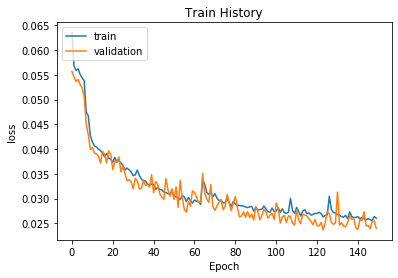

In [39]:
show_train_history(history, 'loss' , 'val_loss')

Then...we create data to do test

In [0]:
N_para_test = 20
N_sample_each_para_test = 40
Nt = 300
vola_long_term_max=1
x_test , y_test = Data_generation( N_para_test , N_sample_each_para_test , Nt , vola_long_term_max )
X_test = np.expand_dims(x_test, axis=2)
predictions = model.predict(X_test)


In [0]:
# Store the parameters
parameters_nn=[]
for i in range(len(predictions)):
  alpha,beta,omega=transform_para_NN_GARCH(predictions[i][0], predictions[i][1] , predictions[i][2] , vola_long_term_max=1)
  parameters_nn.append([alpha, beta, omega])
parameters_origin=[]
for i in range(len(y_test)):
  alpha,beta,omega=transform_para_NN_GARCH(y_test[i][0], y_test[i][1] , y_test[i][2] , vola_long_term_max=1)
  parameters_origin.append([alpha, beta, omega])

Use the ARCH toolkit, which maximizes the likelihood function to estimate the GARCH(1,1) parameters

In [116]:
parameters_GARCH=[]
for i in range(0,len(X_test)):
  model_garch = arch_model(x_test[i,:] , mean='Zero', vol='GARCH', p=1, q=1)
  model_garch_fit = model_garch.fit()
  volatility = model_garch_fit.conditional_volatility
  parameters_GARCH.append([model_garch_fit.params['alpha[1]'],model_garch_fit.params['beta[1]'],model_garch_fit.params['omega']])
#  print(model_garch_fit.params['alpha[1]'],model_garch_fit.params['beta[1]'],model_garch_fit.params['omega'])
#  print(model_garch_fit.summary())

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3178. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2607. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 125.86653076140917
Iteration:      2,   Func. Count:     15,   Neg. LLF: 125.85299134939413
Iteration:      3,   Func. Count:     20,   Neg. LLF: 85.67952553387957
Iteration:      4,   Func. Count:     26,   Neg. LLF: 83.67163145417099
Iteration:      5,   Func. Count:     33,   Neg. LLF: 83.5962195955852
Iteration:      6,   Func. Count:     39,   Neg. LLF: 83.47908550861597
Iteration:      7,   Func. Count:     44,   Neg. LLF: 83.30730248516085
Iteration:      8,   Func. Count:     49,   Neg. LLF: 83.02295569436392
Iteration:      9,   Func. Count:     54,   Neg. LLF: 82.72086208877948
Iteration:     10,   Func. Count:     59,   Neg. LLF: 82.54733903352877
Iteration:     11,   Func. Count:     64,   Neg. LLF: 82.50835935778903
Iteration:     12,   Func. Count:     69,   Neg. LLF: 82.5072392820806
Iteration:     13,   Func. Count:     74,   Neg. LLF: 82.50723410286422
Optimization terminated successfully.    (Exit mode 0)
         

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3345. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0846. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 55.0646761214939
Iteration:      2,   Func. Count:     11,   Neg. LLF: 50.83984720489145
Iteration:      3,   Func. Count:     17,   Neg. LLF: 50.33567733011785
Iteration:      4,   Func. Count:     23,   Neg. LLF: 47.94588457822648
Iteration:      5,   Func. Count:     28,   Neg. LLF: 43.24207749581512
Iteration:      6,   Func. Count:     34,   Neg. LLF: 42.00718009680964
Iteration:      7,   Func. Count:     39,   Neg. LLF: 41.514268987325316
Iteration:      8,   Func. Count:     44,   Neg. LLF: 41.29832557516381
Iteration:      9,   Func. Count:     49,   Neg. LLF: 41.199751172515526
Iteration:     10,   Func. Count:     54,   Neg. LLF: 41.188148771353575
Iteration:     11,   Func. Count:     59,   Neg. LLF: 41.18804367123817
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 41.1880436711571
            Iterations: 11
            Function evaluations: 59
            Gradient evaluations: 

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8542. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2389. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 58.589303044071386
Iteration:      2,   Func. Count:     11,   Neg. LLF: 50.77444638265158
Iteration:      3,   Func. Count:     17,   Neg. LLF: 45.75639316898973
Iteration:      4,   Func. Count:     23,   Neg. LLF: 40.3182060501816
Iteration:      5,   Func. Count:     29,   Neg. LLF: 36.75287280401232
Iteration:      6,   Func. Count:     35,   Neg. LLF: 30.35242109895681
Iteration:      7,   Func. Count:     41,   Neg. LLF: 26.990648629617436
Iteration:      8,   Func. Count:     47,   Neg. LLF: 26.69764391725228
Iteration:      9,   Func. Count:     53,   Neg. LLF: 26.128683054867757
Iteration:     10,   Func. Count:     58,   Neg. LLF: 25.260869457860217
Iteration:     11,   Func. Count:     63,   Neg. LLF: 25.199896291871102
Iteration:     12,   Func. Count:     68,   Neg. LLF: 25.196676326124425
Iteration:     13,   Func. Count:     73,   Neg. LLF: 25.196581694550574
Iteration:     14,   Func. Count:     78,   Neg. LLF: 25.1

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1255. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08651. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      4,   Func. Count:     23,   Neg. LLF: 57.84644799279417
Iteration:      5,   Func. Count:     28,   Neg. LLF: 50.40813608211365
Iteration:      6,   Func. Count:     34,   Neg. LLF: 47.238115879480645
Iteration:      7,   Func. Count:     40,   Neg. LLF: 47.13988238762353
Iteration:      8,   Func. Count:     45,   Neg. LLF: 46.488640865948156
Iteration:      9,   Func. Count:     50,   Neg. LLF: 46.22234366959624
Iteration:     10,   Func. Count:     56,   Neg. LLF: 46.19181126641988
Iteration:     11,   Func. Count:     61,   Neg. LLF: 46.178809623783415
Iteration:     12,   Func. Count:     66,   Neg. LLF: 46.177932938811296
Iteration:     13,   Func. Count:     71,   Neg. LLF: 46.17792344143463
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 46.17792344156473
            Iterations: 13
            Function evaluations: 71
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 100.55263251

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1517. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1499. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:     14,   Func. Count:     78,   Neg. LLF: 53.93183798524039
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 53.93183705758499
            Iterations: 14
            Function evaluations: 79
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      5,   Neg. LLF: 89.94851271543746
Iteration:      2,   Func. Count:     12,   Neg. LLF: 85.85742102622338
Iteration:      3,   Func. Count:     17,   Neg. LLF: 60.22323294707758
Iteration:      4,   Func. Count:     25,   Neg. LLF: 40.89622367551002
Iteration:      5,   Func. Count:     30,   Neg. LLF: 40.83335301950615
Iteration:      6,   Func. Count:     35,   Neg. LLF: 40.83301746192887
Iteration:      7,   Func. Count:     40,   Neg. LLF: 40.831627708513636
Iteration:      8,   Func. Count:     45,   Neg. LLF: 40.82995809800535
Iteration:      9,   Func. Count:     50,   Neg. LLF: 40.829956365402104
Optimization terminated successfully.    (Exit mode 0)
            C

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7973. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3239. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 68.55698925234323
Iteration:      2,   Func. Count:     11,   Neg. LLF: 61.64301159967507
Iteration:      3,   Func. Count:     17,   Neg. LLF: 47.66360372753431
Iteration:      4,   Func. Count:     23,   Neg. LLF: 41.54670381811012
Iteration:      5,   Func. Count:     29,   Neg. LLF: 39.22390870079589
Iteration:      6,   Func. Count:     35,   Neg. LLF: 39.0309655110687
Iteration:      7,   Func. Count:     41,   Neg. LLF: 38.77753009995497
Iteration:      8,   Func. Count:     46,   Neg. LLF: 38.47909553050674
Iteration:      9,   Func. Count:     51,   Neg. LLF: 38.19020089308495
Iteration:     10,   Func. Count:     56,   Neg. LLF: 37.76913584146375
Iteration:     11,   Func. Count:     61,   Neg. LLF: 37.7191110011931
Iteration:     12,   Func. Count:     66,   Neg. LLF: 37.71090781246249
Iteration:     13,   Func. Count:     71,   Neg. LLF: 37.71085519030171
Iteration:     14,   Func. Co

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2926. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6481. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      4,   Func. Count:     24,   Neg. LLF: 136.09003540401795
Iteration:      5,   Func. Count:     30,   Neg. LLF: 135.9303503740064
Iteration:      6,   Func. Count:     36,   Neg. LLF: 135.59346683115055
Iteration:      7,   Func. Count:     41,   Neg. LLF: 135.50098243761022
Iteration:      8,   Func. Count:     46,   Neg. LLF: 135.4850909360976
Iteration:      9,   Func. Count:     51,   Neg. LLF: 135.4827636980048
Iteration:     10,   Func. Count:     56,   Neg. LLF: 135.48036492949467
Iteration:     11,   Func. Count:     61,   Neg. LLF: 135.48036155218045
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 135.48036155220032
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 159.89571354976337
Iteration:      2,   Func. Count:     12,   Neg. LLF: 159.37687705037527
Iteration:      3,   Func. Count:     18,   Neg. LLF: 153.9165

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.5121. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 110.25095218504919
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 160.27650636122343
Iteration:      2,   Func. Count:     12,   Neg. LLF: 158.6995369576116
Iteration:      3,   Func. Count:     18,   Neg. LLF: 155.98621189562851
Iteration:      4,   Func. Count:     24,   Neg. LLF: 154.83650086303652
Iteration:      5,   Func. Count:     30,   Neg. LLF: 154.45912002023462
Iteration:      6,   Func. Count:     35,   Neg. LLF: 154.37662650820664
Iteration:      7,   Func. Count:     40,   Neg. LLF: 154.30513013312105
Iteration:      8,   Func. Count:     45,   Neg. LLF: 154.30085574814842
Iteration:      9,   Func. Count:     50,   Neg. LLF: 154.30070033004895
Iteration:     10,   Func. Count:     55,   Neg. LLF: 154.30065853748323
Iteration:     11,   Func. Count:     60,   Neg. LLF: 154.3006

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1718. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 111.67537558807511
            Iterations: 12
            Function evaluations: 64
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 182.7488346868869
Iteration:      2,   Func. Count:     11,   Neg. LLF: 173.9500714304774
Iteration:      3,   Func. Count:     17,   Neg. LLF: 161.6102215611299
Iteration:      4,   Func. Count:     23,   Neg. LLF: 160.59500240188592
Iteration:      5,   Func. Count:     29,   Neg. LLF: 159.32975916498614
Iteration:      6,   Func. Count:     34,   Neg. LLF: 158.69496604632164
Iteration:      7,   Func. Count:     39,   Neg. LLF: 158.66835034303483
Iteration:      8,   Func. Count:     44,   Neg. LLF: 158.6663551706076
Iteration:      9,   Func. Count:     49,   Neg. LLF: 158.66468018046862
Iteration:     10,   Func. Count:     54,   Neg. LLF: 158.66462109473707
Iteration:     11,   Func. Count:     59,   Neg. LLF: 158.66461

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3704. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1922. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      2,   Func. Count:     11,   Neg. LLF: 146.59795785007597
Iteration:      3,   Func. Count:     18,   Neg. LLF: 146.11777958560924
Iteration:      4,   Func. Count:     24,   Neg. LLF: 143.45134199567443
Iteration:      5,   Func. Count:     30,   Neg. LLF: 141.97504437776158
Iteration:      6,   Func. Count:     36,   Neg. LLF: 140.700906413344
Iteration:      7,   Func. Count:     42,   Neg. LLF: 140.54951990544504
Iteration:      8,   Func. Count:     47,   Neg. LLF: 140.26806137575886
Iteration:      9,   Func. Count:     52,   Neg. LLF: 140.23238472062107
Iteration:     10,   Func. Count:     57,   Neg. LLF: 140.23144083267263
Iteration:     11,   Func. Count:     62,   Neg. LLF: 140.23143094442977
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 140.23143094435343
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 164.335

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2288. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2593. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 218.24127627711442
Iteration:      2,   Func. Count:     11,   Neg. LLF: 215.81250582238582
Iteration:      3,   Func. Count:     17,   Neg. LLF: 210.4225463755121
Iteration:      4,   Func. Count:     23,   Neg. LLF: 209.1872359793036
Iteration:      5,   Func. Count:     28,   Neg. LLF: 205.5703617556808
Iteration:      6,   Func. Count:     34,   Neg. LLF: 203.59893699005843
Iteration:      7,   Func. Count:     39,   Neg. LLF: 202.95852612765094
Iteration:      8,   Func. Count:     44,   Neg. LLF: 202.73179550321683
Iteration:      9,   Func. Count:     49,   Neg. LLF: 202.6942545999167
Iteration:     10,   Func. Count:     54,   Neg. LLF: 202.69153669984001
Iteration:     11,   Func. Count:     59,   Neg. LLF: 202.69116908663216
Iteration:     12,   Func. Count:     64,   Neg. LLF: 202.6909153364441
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 202.69091488269964
            Iterati

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4338. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      2,   Func. Count:     11,   Neg. LLF: 165.5312092992179
Iteration:      3,   Func. Count:     17,   Neg. LLF: 165.16091768900387
Iteration:      4,   Func. Count:     23,   Neg. LLF: 162.20926138659894
Iteration:      5,   Func. Count:     29,   Neg. LLF: 160.7892742738108
Iteration:      6,   Func. Count:     35,   Neg. LLF: 158.26805942419642
Iteration:      7,   Func. Count:     41,   Neg. LLF: 158.0744898932265
Iteration:      8,   Func. Count:     46,   Neg. LLF: 157.96979430919947
Iteration:      9,   Func. Count:     51,   Neg. LLF: 157.96003639670306
Iteration:     10,   Func. Count:     56,   Neg. LLF: 157.95792483782054
Iteration:     11,   Func. Count:     61,   Neg. LLF: 157.9578287122996
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 157.95782816884412
            Iterations: 11
            Function evaluations: 62
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 159.85940

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.247. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      9,   Func. Count:     50,   Neg. LLF: 156.9161998057157
Iteration:     10,   Func. Count:     55,   Neg. LLF: 156.91592178985607
Iteration:     11,   Func. Count:     60,   Neg. LLF: 156.9159112230501
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 156.91591122296725
            Iterations: 11
            Function evaluations: 60
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 149.19409796228507
Iteration:      2,   Func. Count:     11,   Neg. LLF: 146.4410046456517
Iteration:      3,   Func. Count:     17,   Neg. LLF: 146.14301509829312
Iteration:      4,   Func. Count:     23,   Neg. LLF: 144.1446772159122
Iteration:      5,   Func. Count:     29,   Neg. LLF: 142.96919947492302
Iteration:      6,   Func. Count:     36,   Neg. LLF: 142.96289305603892
Iteration:      7,   Func. Count:     41,   Neg. LLF: 142.66284874276852
Iteration:      8,   Func. Count:     46,   Neg. LLF: 142.64489

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.5867. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

330.25660926175914
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 339.6653452742799
Iteration:      2,   Func. Count:     11,   Neg. LLF: 338.3050654531196
Iteration:      3,   Func. Count:     18,   Neg. LLF: 338.23294340674147
Iteration:      4,   Func. Count:     24,   Neg. LLF: 337.6639402858518
Iteration:      5,   Func. Count:     29,   Neg. LLF: 337.5898585888121
Iteration:      6,   Func. Count:     34,   Neg. LLF: 337.58145805946776
Iteration:      7,   Func. Count:     39,   Neg. LLF: 337.5802064766259
Iteration:      8,   Func. Count:     44,   Neg. LLF: 337.5801702073047
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 337.5801702075211
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 369.4615534731226
Iteration:      2,   Fun

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7257. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 384.83984679017703
Iteration:      2,   Func. Count:     14,   Neg. LLF: 384.8289368246469
Iteration:      3,   Func. Count:     20,   Neg. LLF: 377.905949347105
Iteration:      4,   Func. Count:     26,   Neg. LLF: 377.83943149135223
Iteration:      5,   Func. Count:     31,   Neg. LLF: 377.50681543217183
Iteration:      6,   Func. Count:     36,   Neg. LLF: 377.3159961181184
Iteration:      7,   Func. Count:     41,   Neg. LLF: 377.25800746439813
Iteration:      8,   Func. Count:     46,   Neg. LLF: 377.1687994646576
Iteration:      9,   Func. Count:     51,   Neg. LLF: 377.1594225149908
Iteration:     10,   Func. Count:     56,   Neg. LLF: 377.1583416926218
Iteration:     11,   Func. Count:     61,   Neg. LLF: 377.1583063146222
Iteration:     12,   Func. Count:     66,   Neg. LLF: 377.15830468900344
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 377.15830468893455
            Iterations

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 396.90216739130716
Iteration:      2,   Func. Count:     11,   Neg. LLF: 392.2616236762101
Iteration:      3,   Func. Count:     17,   Neg. LLF: 391.47778877019346
Iteration:      4,   Func. Count:     23,   Neg. LLF: 388.87891981406693
Iteration:      5,   Func. Count:     28,   Neg. LLF: 383.0717128485295
Iteration:      6,   Func. Count:     34,   Neg. LLF: 382.3690545203151
Iteration:      7,   Func. Count:     39,   Neg. LLF: 381.5593129038575
Iteration:      8,   Func. Count:     44,   Neg. LLF: 381.19600333706666
Iteration:      9,   Func. Count:     49,   Neg. LLF: 381.1545487688468
Iteration:     10,   Func. Count:     54,   Neg. LLF: 381.15305377620234
Iteration:     11,   Func. Count:     59,   Neg. LLF: 381.15302929611266
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 381.1530286938649
            Iterations: 11
            Function evaluations: 60
            Gradient evaluati

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6862. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9881. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 386.3084633203748
Iteration:      2,   Func. Count:     12,   Neg. LLF: 385.82784794895144
Iteration:      3,   Func. Count:     18,   Neg. LLF: 382.62499026852885
Iteration:      4,   Func. Count:     24,   Neg. LLF: 380.00180929276513
Iteration:      5,   Func. Count:     30,   Neg. LLF: 379.8049770283586
Iteration:      6,   Func. Count:     35,   Neg. LLF: 379.64031844738366
Iteration:      7,   Func. Count:     40,   Neg. LLF: 379.5863945567161
Iteration:      8,   Func. Count:     45,   Neg. LLF: 379.56443045767423
Iteration:      9,   Func. Count:     50,   Neg. LLF: 379.54424893022207
Iteration:     10,   Func. Count:     55,   Neg. LLF: 379.54361462966665
Iteration:     11,   Func. Count:     60,   Neg. LLF: 379.5436085603119
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 379.5436085602835
            Iterations: 11
            Function evaluations: 60
            Gradient evaluat

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7728. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4009. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 279.8757367756248
Iteration:      2,   Func. Count:     11,   Neg. LLF: 279.582730447628
Iteration:      3,   Func. Count:     18,   Neg. LLF: 279.48608336727716
Iteration:      4,   Func. Count:     25,   Neg. LLF: 279.44998526598613
Iteration:      5,   Func. Count:     32,   Neg. LLF: 279.4477565392392
Iteration:      6,   Func. Count:     37,   Neg. LLF: 279.4414670929405
Iteration:      7,   Func. Count:     42,   Neg. LLF: 279.4414148869623
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 279.4414148870969
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 230.25370485735263
Iteration:      2,   Func. Count:     11,   Neg. LLF: 228.8237796910912
Iteration:      3,   Func. Count:     18,   Neg. LLF: 228.64230117198494
Iteration:      4,   Func. Count:     24,   Neg. LLF: 228.06529341935

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6299. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3528. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 269.0828290923919
Iteration:      2,   Func. Count:     12,   Neg. LLF: 268.6037842443322
Iteration:      3,   Func. Count:     18,   Neg. LLF: 265.063477652739
Iteration:      4,   Func. Count:     24,   Neg. LLF: 262.5380336186322
Iteration:      5,   Func. Count:     30,   Neg. LLF: 262.2157061471213
Iteration:      6,   Func. Count:     35,   Neg. LLF: 262.0031743925129
Iteration:      7,   Func. Count:     40,   Neg. LLF: 261.93183125490566
Iteration:      8,   Func. Count:     45,   Neg. LLF: 261.91564840960916
Iteration:      9,   Func. Count:     50,   Neg. LLF: 261.8919986477352
Iteration:     10,   Func. Count:     55,   Neg. LLF: 261.89176465998366
Iteration:     11,   Func. Count:     60,   Neg. LLF: 261.89176100220016
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 261.89176100219237
            Iterations: 11
            Function evaluations: 60
            Gradient evaluation

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9342. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7916. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:     11,   Func. Count:     61,   Neg. LLF: 339.9754828727845
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 339.9754828728684
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 248.1099169540482
Iteration:      2,   Func. Count:     12,   Neg. LLF: 247.9208170027109
Iteration:      3,   Func. Count:     19,   Neg. LLF: 247.8927052042706
Iteration:      4,   Func. Count:     25,   Neg. LLF: 247.86934396140984
Iteration:      5,   Func. Count:     31,   Neg. LLF: 247.8594785288601
Iteration:      6,   Func. Count:     37,   Neg. LLF: 247.85719932835727
Iteration:      7,   Func. Count:     43,   Neg. LLF: 247.85674955800013
Iteration:      8,   Func. Count:     48,   Neg. LLF: 247.85674836378323
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 247.85674836387207
            Iterations: 8
  

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8506. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.438. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y


Iteration:      5,   Func. Count:     30,   Neg. LLF: 268.04588113064347
Iteration:      6,   Func. Count:     35,   Neg. LLF: 267.959640579016
Iteration:      7,   Func. Count:     40,   Neg. LLF: 267.95390650458035
Iteration:      8,   Func. Count:     45,   Neg. LLF: 267.95372212776533
Iteration:      9,   Func. Count:     50,   Neg. LLF: 267.9537209480083
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 267.9537209479438
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 351.74432061335835
Iteration:      2,   Func. Count:     11,   Neg. LLF: 344.2435124270082
Iteration:      3,   Func. Count:     17,   Neg. LLF: 323.3889413829916
Iteration:      4,   Func. Count:     23,   Neg. LLF: 321.8353823359049
Iteration:      5,   Func. Count:     29,   Neg. LLF: 321.81363907768133
Iteration:      6,   Func. Count:     35,   Neg. LLF: 321.546204170

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.5489. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3469. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      7,   Func. Count:     40,   Neg. LLF: 230.68161242079537
Iteration:      8,   Func. Count:     45,   Neg. LLF: 230.67125796824178
Iteration:      9,   Func. Count:     50,   Neg. LLF: 230.67097463864337
Iteration:     10,   Func. Count:     55,   Neg. LLF: 230.67097207721108
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 230.67097207726664
            Iterations: 10
            Function evaluations: 55
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 333.26565841597824
Iteration:      2,   Func. Count:     11,   Neg. LLF: 331.4968319177455
Iteration:      3,   Func. Count:     17,   Neg. LLF: 324.2885478698564
Iteration:      4,   Func. Count:     23,   Neg. LLF: 321.2913196142955
Iteration:      5,   Func. Count:     29,   Neg. LLF: 320.1241829772256
Iteration:      6,   Func. Count:     35,   Neg. LLF: 319.49244601606176
Iteration:      7,   Func. Count:     40,   Neg. LLF: 318.90450

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.531. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      1,   Func. Count:      5,   Neg. LLF: 304.3506459991925
Iteration:      2,   Func. Count:     11,   Neg. LLF: 299.3169883537469
Iteration:      3,   Func. Count:     17,   Neg. LLF: 298.9486115025908
Iteration:      4,   Func. Count:     23,   Neg. LLF: 296.2991649500026
Iteration:      5,   Func. Count:     29,   Neg. LLF: 294.75792024168584
Iteration:      6,   Func. Count:     35,   Neg. LLF: 293.4811668743434
Iteration:      7,   Func. Count:     41,   Neg. LLF: 293.06629586934497
Iteration:      8,   Func. Count:     46,   Neg. LLF: 293.04613184607774
Iteration:      9,   Func. Count:     51,   Neg. LLF: 293.04595628120336
Iteration:     10,   Func. Count:     56,   Neg. LLF: 293.0459353587749
Iteration:     11,   Func. Count:     61,   Neg. LLF: 293.0459329334665
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 293.0459329334576
            Iterations: 11
            Function evaluations: 61
            Gradient evaluation

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4846. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 354.04957898587855
Iteration:      2,   Func. Count:     11,   Neg. LLF: 348.96608044553847
Iteration:      3,   Func. Count:     17,   Neg. LLF: 339.1809220950794
Iteration:      4,   Func. Count:     23,   Neg. LLF: 336.9141676347961
Iteration:      5,   Func. Count:     29,   Neg. LLF: 336.0656241489651
Iteration:      6,   Func. Count:     35,   Neg. LLF: 335.56400880705064
Iteration:      7,   Func. Count:     40,   Neg. LLF: 335.2672345511595
Iteration:      8,   Func. Count:     45,   Neg. LLF: 335.153021491047
Iteration:      9,   Func. Count:     50,   Neg. LLF: 335.1301401119722
Iteration:     10,   Func. Count:     55,   Neg. LLF: 335.1054837389077
Iteration:     11,   Func. Count:     60,   Neg. LLF: 335.104786726303
Iteration:     12,   Func. Count:     65,   Neg. LLF: 335.1047604939184
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 335.10476049396357
            Iterations: 1

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8858. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9265. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 366.04042818367986
Iteration:      2,   Func. Count:     11,   Neg. LLF: 361.0017435938933
Iteration:      3,   Func. Count:     17,   Neg. LLF: 359.8166118959958
Iteration:      4,   Func. Count:     23,   Neg. LLF: 357.6762254116088
Iteration:      5,   Func. Count:     29,   Neg. LLF: 357.368443218292
Iteration:      6,   Func. Count:     35,   Neg. LLF: 356.2860819526271
Iteration:      7,   Func. Count:     40,   Neg. LLF: 356.2104440506839
Iteration:      8,   Func. Count:     45,   Neg. LLF: 356.20847545178617
Iteration:      9,   Func. Count:     50,   Neg. LLF: 356.2084685568826
Iteration:     10,   Func. Count:     55,   Neg. LLF: 356.2084673522038
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 356.2084673522041
            Iterations: 10
            Function evaluations: 55
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 349.02781324972

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.5668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 310.9348634669642
Iteration:      2,   Func. Count:     12,   Neg. LLF: 310.3914980111757
Iteration:      3,   Func. Count:     18,   Neg. LLF: 307.46724050452895
Iteration:      4,   Func. Count:     23,   Neg. LLF: 304.0670960325539
Iteration:      5,   Func. Count:     30,   Neg. LLF: 302.87697882149655
Iteration:      6,   Func. Count:     36,   Neg. LLF: 301.805534380148
Iteration:      7,   Func. Count:     41,   Neg. LLF: 301.02652504213836
Iteration:      8,   Func. Count:     46,   Neg. LLF: 300.91046007887894
Iteration:      9,   Func. Count:     51,   Neg. LLF: 300.8804369506006
Iteration:     10,   Func. Count:     56,   Neg. LLF: 300.8345490332431
Iteration:     11,   Func. Count:     61,   Neg. LLF: 300.8342295386635
Iteration:     12,   Func. Count:     66,   Neg. LLF: 300.83416360045203
Iteration:     13,   Func. Count:     71,   Neg. LLF: 300.8339798165454
Iteration:     14,   Func. Count:     76,   Neg. LLF: 300.83

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.5326. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7461. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

            Current function value: 350.92107526751863
            Iterations: 14
            Function evaluations: 76
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      5,   Neg. LLF: 334.69563755251863
Iteration:      2,   Func. Count:     11,   Neg. LLF: 332.67368818806017
Iteration:      3,   Func. Count:     18,   Neg. LLF: 332.5395445189007
Iteration:      4,   Func. Count:     24,   Neg. LLF: 331.76613780691406
Iteration:      5,   Func. Count:     29,   Neg. LLF: 331.2392049584913
Iteration:      6,   Func. Count:     34,   Neg. LLF: 331.1990827850228
Iteration:      7,   Func. Count:     39,   Neg. LLF: 331.1825245698648
Iteration:      8,   Func. Count:     44,   Neg. LLF: 331.18219308576283
Iteration:      9,   Func. Count:     49,   Neg. LLF: 331.1821544468135
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 331.18215444663855
            Iterations: 9
            Function evaluations: 49
            Gradien

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.5477. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      1,   Func. Count:      5,   Neg. LLF: 303.4597953164945
Iteration:      2,   Func. Count:     11,   Neg. LLF: 302.7027135621751
Iteration:      3,   Func. Count:     17,   Neg. LLF: 301.38377744974053
Iteration:      4,   Func. Count:     22,   Neg. LLF: 299.97028743241776
Iteration:      5,   Func. Count:     28,   Neg. LLF: 299.93819629966623
Iteration:      6,   Func. Count:     34,   Neg. LLF: 299.5247522522542
Iteration:      7,   Func. Count:     39,   Neg. LLF: 299.4445152081107
Iteration:      8,   Func. Count:     44,   Neg. LLF: 299.40714464368955
Iteration:      9,   Func. Count:     49,   Neg. LLF: 299.40014915076483
Iteration:     10,   Func. Count:     54,   Neg. LLF: 299.3995952821989
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 299.3995952822718
            Iterations: 10
            Function evaluations: 54
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 384.1133523

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.5865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: -432.8968852193025
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -432.89688926223084
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -440.13940914288946
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -440.13941113702435
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -421.7792395505884
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -421.77924204491967
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -414.7028076689969
Iteration:      2,   Func. Count:     11,   Neg. LLF:

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0107. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: -446.1683727091487
Iteration:      2,   Func. Count:     11,   Neg. LLF: -451.22224699930155
Iteration:      3,   Func. Count:     18,   Neg. LLF: -451.49485958504386
Iteration:      4,   Func. Count:     25,   Neg. LLF: -451.56012550915625
Iteration:      5,   Func. Count:     31,   Neg. LLF: -451.8037456234125
Iteration:      6,   Func. Count:     37,   Neg. LLF: -451.930518204864
Iteration:      7,   Func. Count:     42,   Neg. LLF: -452.12059686428586
Iteration:      8,   Func. Count:     47,   Neg. LLF: -452.1869443436492
Iteration:      9,   Func. Count:     52,   Neg. LLF: -452.23519410376593
Iteration:     10,   Func. Count:     57,   Neg. LLF: -452.24206793777944
Iteration:     11,   Func. Count:     62,   Neg. LLF: -452.2421769246915
Iteration:     12,   Func. Count:     67,   Neg. LLF: -452.24218016539976
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -452.24218047725344
       

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002427. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003508. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceW

Iteration:      1,   Func. Count:      5,   Neg. LLF: -432.7289766769791
Iteration:      2,   Func. Count:     15,   Neg. LLF: -432.8603599628069
Iteration:      3,   Func. Count:     21,   Neg. LLF: -445.58176074626647
Iteration:      4,   Func. Count:     27,   Neg. LLF: -447.5523582674978
Iteration:      5,   Func. Count:     33,   Neg. LLF: -447.88823937133736
Iteration:      6,   Func. Count:     39,   Neg. LLF: -448.35625626696475
Iteration:      7,   Func. Count:     45,   Neg. LLF: -448.4884349559643
Iteration:      8,   Func. Count:     50,   Neg. LLF: -448.62612352095084
Iteration:      9,   Func. Count:     55,   Neg. LLF: -448.64996916274254
Iteration:     10,   Func. Count:     60,   Neg. LLF: -448.65230391619025
Iteration:     11,   Func. Count:     65,   Neg. LLF: -448.65233881245683
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -448.6523388121959
            Iterations: 11
            Function evaluations: 65
            Grad

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0376. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01445. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarnin

Iteration:      9,   Func. Count:     56,   Neg. LLF: -478.9847412194035
Iteration:     10,   Func. Count:     61,   Neg. LLF: -478.99458227588144
Iteration:     11,   Func. Count:     66,   Neg. LLF: -479.01162795322534
Iteration:     12,   Func. Count:     71,   Neg. LLF: -479.0118160396429
Iteration:     13,   Func. Count:     76,   Neg. LLF: -479.0118446616824
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -479.01184496472865
            Iterations: 13
            Function evaluations: 77
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: -463.83091864928974
Iteration:      2,   Func. Count:     12,   Neg. LLF: -466.751751422385
Iteration:      3,   Func. Count:     24,   Neg. LLF: -469.0404347036847
Iteration:      4,   Func. Count:     30,   Neg. LLF: -477.3407607618924
Iteration:      5,   Func. Count:     36,   Neg. LLF: -480.4639127545639
Iteration:      6,   Func. Count:     42,   Neg. LLF: -4

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002585. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarni

Iteration:      4,   Func. Count:     27,   Neg. LLF: -459.2229265813251
Iteration:      5,   Func. Count:     33,   Neg. LLF: -460.1036443085218
Iteration:      6,   Func. Count:     39,   Neg. LLF: -460.31425181834794
Iteration:      7,   Func. Count:     45,   Neg. LLF: -460.94374710331317
Iteration:      8,   Func. Count:     51,   Neg. LLF: -461.0913179144164
Iteration:      9,   Func. Count:     56,   Neg. LLF: -461.12969650920337
Iteration:     10,   Func. Count:     61,   Neg. LLF: -461.13026266461617
Iteration:     11,   Func. Count:     66,   Neg. LLF: -461.1303310289876
Iteration:     12,   Func. Count:     71,   Neg. LLF: -461.1303320305272
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -461.13033203054533
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: -458.26619191118317
Iteration:      2,   Func. Count:     11,   Neg. LLF:

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007227. Parameter
estimation work better when this value is between 1 and 100

7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -449.70307776793356
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -449.7030799100843
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -495.715887518587
Iteration:      2,   Func. Count:     12,   Neg. LLF: -496.4326833489575
Iteration:      3,   Func. Count:     19,   Neg. LLF: -496.5484658955134
Iteration:      4,   Func. Count:     27,   Neg. LLF: -496.55019609879
Iteration:      5,   Func. Count:     33,   Neg. LLF: -496.61830243294196
Iteration:      6,   Func. Count:     39,   Neg. LLF: -496.6642995630222
Iteration:      7,   Func. Count:     44,   Neg. LLF: -496.67941227211054
Iteration:      8,   Func. Count:     49,   Neg. LLF: -496.68313033663617
Iteration:      9,   Func. Count:     54,   Neg. LLF: -496.6832205474516
Iteration:     10,   Func. Count:     59,   Neg. L

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7375. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.813. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      1,   Func. Count:      5,   Neg. LLF: 376.35767021589277
Iteration:      2,   Func. Count:     11,   Neg. LLF: 374.39134438027367
Iteration:      3,   Func. Count:     18,   Neg. LLF: 374.1915683428333
Iteration:      4,   Func. Count:     24,   Neg. LLF: 373.5651574806243
Iteration:      5,   Func. Count:     29,   Neg. LLF: 370.6724337365688
Iteration:      6,   Func. Count:     34,   Neg. LLF: 370.6559643119826
Iteration:      7,   Func. Count:     39,   Neg. LLF: 370.6506913980185
Iteration:      8,   Func. Count:     44,   Neg. LLF: 370.6506284599884
Iteration:      9,   Func. Count:     49,   Neg. LLF: 370.6506236391117
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 370.65062348281856
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 331.2144691414443
Iteration:      2,   Func. Count:     11,   Neg. LLF: 327.13938878399

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9305. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 361.9340620465315
Iteration:      2,   Func. Count:     11,   Neg. LLF: 359.52695266562284
Iteration:      3,   Func. Count:     18,   Neg. LLF: 359.2350289123255
Iteration:      4,   Func. Count:     24,   Neg. LLF: 358.38757153998756
Iteration:      5,   Func. Count:     30,   Neg. LLF: 357.70375767633186
Iteration:      6,   Func. Count:     35,   Neg. LLF: 357.65944182899653
Iteration:      7,   Func. Count:     40,   Neg. LLF: 357.65769016206264
Iteration:      8,   Func. Count:     45,   Neg. LLF: 357.65761595061923
Iteration:      9,   Func. Count:     50,   Neg. LLF: 357.65760783249027
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 357.65760783248703
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 404.41083935702204
Iteration:      2,   Func. Count:     11,   Neg. LLF: 400.15681

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9034. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9746. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      3,   Func. Count:     17,   Neg. LLF: 388.70022738479423
Iteration:      4,   Func. Count:     23,   Neg. LLF: 385.51300917651355
Iteration:      5,   Func. Count:     28,   Neg. LLF: 384.7196117295822
Iteration:      6,   Func. Count:     34,   Neg. LLF: 384.4442955331483
Iteration:      7,   Func. Count:     39,   Neg. LLF: 384.3214988657036
Iteration:      8,   Func. Count:     44,   Neg. LLF: 384.3202140004252
Iteration:      9,   Func. Count:     49,   Neg. LLF: 384.3202109072564
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 384.3202109073601
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 413.60520271199516
Iteration:      2,   Func. Count:     11,   Neg. LLF: 408.38146379778186
Iteration:      3,   Func. Count:     17,   Neg. LLF: 407.3416438781564
Iteration:      4,   Func. Count:     23,   Neg. LLF: 404.0587443736

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8038. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.9355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 


Iteration:      8,   Func. Count:     43,   Neg. LLF: 372.48799289018973
Iteration:      9,   Func. Count:     48,   Neg. LLF: 372.48767664373463
Iteration:     10,   Func. Count:     53,   Neg. LLF: 372.4876750172292
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 372.487675001645
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 393.1989986778251
Iteration:      2,   Func. Count:     11,   Neg. LLF: 390.47754238467144
Iteration:      3,   Func. Count:     18,   Neg. LLF: 390.2970296090521
Iteration:      4,   Func. Count:     24,   Neg. LLF: 388.7460235102266
Iteration:      5,   Func. Count:     29,   Neg. LLF: 386.15599639367025
Iteration:      6,   Func. Count:     35,   Neg. LLF: 386.0854850473651
Iteration:      7,   Func. Count:     40,   Neg. LLF: 386.0215720306182
Iteration:      8,   Func. Count:     45,   Neg. LLF: 386.01400011

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.833. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6892. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      1,   Func. Count:      5,   Neg. LLF: 377.7311379330707
Iteration:      2,   Func. Count:     11,   Neg. LLF: 374.49831925175545
Iteration:      3,   Func. Count:     18,   Neg. LLF: 374.260893549926
Iteration:      4,   Func. Count:     24,   Neg. LLF: 372.75982416248223
Iteration:      5,   Func. Count:     30,   Neg. LLF: 372.4362105314285
Iteration:      6,   Func. Count:     36,   Neg. LLF: 372.03724253845223
Iteration:      7,   Func. Count:     41,   Neg. LLF: 371.9679292471401
Iteration:      8,   Func. Count:     46,   Neg. LLF: 371.96210843060226
Iteration:      9,   Func. Count:     51,   Neg. LLF: 371.96157531890833
Iteration:     10,   Func. Count:     56,   Neg. LLF: 371.96157343158114
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 371.96157343158154
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 360.276295

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6338. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01392. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 352.4412093116983
Iteration:      2,   Func. Count:     13,   Neg. LLF: 352.4280164265331
Iteration:      3,   Func. Count:     19,   Neg. LLF: 352.11038214420074
Iteration:      4,   Func. Count:     24,   Neg. LLF: 350.8898580888211
Iteration:      5,   Func. Count:     30,   Neg. LLF: 350.811881516638
Iteration:      6,   Func. Count:     35,   Neg. LLF: 350.8021209487769
Iteration:      7,   Func. Count:     40,   Neg. LLF: 350.79901820206106
Iteration:      8,   Func. Count:     45,   Neg. LLF: 350.79901165574273
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 350.79901165576405
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -227.86800364200528
Iteration:      2,   Func. Count:     11,   Neg. LLF: -229.87724866425802
Iteration:      3,   Func. Count:     18,   Neg. LLF: -229.968935

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02119. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01978. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: -171.30983127675665
Iteration:      2,   Func. Count:     11,   Neg. LLF: -174.1435124525686
Iteration:      3,   Func. Count:     18,   Neg. LLF: -174.21648547434728
Iteration:      4,   Func. Count:     24,   Neg. LLF: -175.38147192738802
Iteration:      5,   Func. Count:     30,   Neg. LLF: -175.6243996553461
Iteration:      6,   Func. Count:     36,   Neg. LLF: -175.9227336576428
Iteration:      7,   Func. Count:     43,   Neg. LLF: -175.926859295302
Iteration:      8,   Func. Count:     48,   Neg. LLF: -175.93115894396993
Iteration:      9,   Func. Count:     53,   Neg. LLF: -175.93148941028835
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -175.93148941016327
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -201.7765259024116
Iteration:      2,   Func. Count:     15,   Neg. LLF: -2

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01808. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: -211.76337498333731
Iteration:      2,   Func. Count:     11,   Neg. LLF: -214.44154610554523
Iteration:      3,   Func. Count:     17,   Neg. LLF: -215.9850787477858
Iteration:      4,   Func. Count:     24,   Neg. LLF: -215.99708639695825
Iteration:      5,   Func. Count:     31,   Neg. LLF: -216.25732282096487
Iteration:      6,   Func. Count:     38,   Neg. LLF: -216.25756529576353
Iteration:      7,   Func. Count:     43,   Neg. LLF: -216.26108464069318
Iteration:      8,   Func. Count:     48,   Neg. LLF: -216.26156272251433
Iteration:      9,   Func. Count:     53,   Neg. LLF: -216.2615646945826
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -216.26156469459346
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -179.28053106942428
Iteration:      2,   Func. Count:     11,   Neg. LLF

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01391. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: -249.5490336130353
Iteration:      2,   Func. Count:     12,   Neg. LLF: -249.58196088316387
Iteration:      3,   Func. Count:     19,   Neg. LLF: -249.58400578261407
Iteration:      4,   Func. Count:     26,   Neg. LLF: -249.5921894168742
Iteration:      5,   Func. Count:     33,   Neg. LLF: -249.60079981338424
Iteration:      6,   Func. Count:     38,   Neg. LLF: -249.6026153036808
Iteration:      7,   Func. Count:     43,   Neg. LLF: -249.60390845880008
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -249.60390845901793
            Iterations: 7
            Function evaluations: 43
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -204.09645651116196
Iteration:      2,   Func. Count:     11,   Neg. LLF: -204.95651716511475
Iteration:      3,   Func. Count:     18,   Neg. LLF: -204.96417202596604
Iteration:      4,   Func. Count:     24,   Neg. LLF:

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01162. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01592. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: -163.2850441047344
Iteration:      2,   Func. Count:     11,   Neg. LLF: -166.11516355789888
Iteration:      3,   Func. Count:     18,   Neg. LLF: -166.24195264600684
Iteration:      4,   Func. Count:     24,   Neg. LLF: -167.29572306794356
Iteration:      5,   Func. Count:     30,   Neg. LLF: -167.50292345827887
Iteration:      6,   Func. Count:     36,   Neg. LLF: -167.52249321862718
Iteration:      7,   Func. Count:     42,   Neg. LLF: -167.54945745013956
Iteration:      8,   Func. Count:     47,   Neg. LLF: -167.5507084161869
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -167.55070896565468
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -210.74993392413768
Iteration:      2,   Func. Count:     11,   Neg. LLF: -213.77670897049637
Iteration:      3,   Func. Count:     17,   Neg. LLF

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01821. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: 126.57813726666485
Iteration:      2,   Func. Count:     11,   Neg. LLF: 119.64299369248879
Iteration:      3,   Func. Count:     17,   Neg. LLF: 116.16094517778171
Iteration:      4,   Func. Count:     23,   Neg. LLF: 112.02271629061576
Iteration:      5,   Func. Count:     28,   Neg. LLF: 103.0926766809109
Iteration:      6,   Func. Count:     34,   Neg. LLF: 101.75281366101427
Iteration:      7,   Func. Count:     39,   Neg. LLF: 100.20991593841653
Iteration:      8,   Func. Count:     44,   Neg. LLF: 99.93372803585231
Iteration:      9,   Func. Count:     49,   Neg. LLF: 99.75885553846311
Iteration:     10,   Func. Count:     54,   Neg. LLF: 99.69129762856437
Iteration:     11,   Func. Count:     60,   Neg. LLF: 99.68036929864135
Iteration:     12,   Func. Count:     65,   Neg. LLF: 99.67909101996966
Iteration:     13,   Func. Count:     70,   Neg. LLF: 99.6789001866322
Optimization terminated successfully.    (Exit mode 0)
    

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2813. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:     13,   Func. Count:     72,   Neg. LLF: 103.61840693906662
Iteration:     14,   Func. Count:     77,   Neg. LLF: 103.58579585374243
Iteration:     15,   Func. Count:     82,   Neg. LLF: 103.58503441646076
Iteration:     16,   Func. Count:     87,   Neg. LLF: 103.58503059161362
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 103.58503060092926
            Iterations: 16
            Function evaluations: 87
            Gradient evaluations: 16
Iteration:      1,   Func. Count:      5,   Neg. LLF: 55.950203084775346
Iteration:      2,   Func. Count:     11,   Neg. LLF: 51.99145776281581
Iteration:      3,   Func. Count:     17,   Neg. LLF: 50.6049096255033
Iteration:      4,   Func. Count:     23,   Neg. LLF: 47.55058885975424
Iteration:      5,   Func. Count:     28,   Neg. LLF: 44.98509323529822
Iteration:      6,   Func. Count:     34,   Neg. LLF: 44.4954395295209
Iteration:      7,   Func. Count:     40,   Neg. LLF: 44.385146037

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1619. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1977. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      8,   Func. Count:     46,   Neg. LLF: 39.14508868241366
Iteration:      9,   Func. Count:     51,   Neg. LLF: 39.13792870475379
Iteration:     10,   Func. Count:     56,   Neg. LLF: 39.13614925306338
Iteration:     11,   Func. Count:     61,   Neg. LLF: 39.13361992725014
Iteration:     12,   Func. Count:     66,   Neg. LLF: 39.13361758622949
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 39.13361758620306
            Iterations: 12
            Function evaluations: 66
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 174.40758707276163
Iteration:      2,   Func. Count:     11,   Neg. LLF: 164.5397823547549
Iteration:      3,   Func. Count:     17,   Neg. LLF: 146.70294251904193
Iteration:      4,   Func. Count:     22,   Neg. LLF: 139.44787586968334
Iteration:      5,   Func. Count:     27,   Neg. LLF: 137.07478725821335
Iteration:      6,   Func. Count:     33,   Neg. LLF: 133.94688966

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      4,   Func. Count:     23,   Neg. LLF: 93.39259447286065
Iteration:      5,   Func. Count:     28,   Neg. LLF: 89.77191663927712
Iteration:      6,   Func. Count:     34,   Neg. LLF: 87.55349831777038
Iteration:      7,   Func. Count:     40,   Neg. LLF: 87.36638621512454
Iteration:      8,   Func. Count:     46,   Neg. LLF: 83.66724431418349
Iteration:      9,   Func. Count:     51,   Neg. LLF: 82.708160745611
Iteration:     10,   Func. Count:     56,   Neg. LLF: 82.45109244749437
Iteration:     11,   Func. Count:     61,   Neg. LLF: 82.27367003777479
Iteration:     12,   Func. Count:     66,   Neg. LLF: 82.05664314687785
Iteration:     13,   Func. Count:     71,   Neg. LLF: 82.03079870191272
Iteration:     14,   Func. Count:     76,   Neg. LLF: 82.0254095563581
Iteration:     15,   Func. Count:     81,   Neg. LLF: 82.02473398685243
Iteration:     16,   Func. Count:     86,   Neg. LLF: 82.0247165386001
Optimization terminated successfully.    (Exit mode 0)
            C

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3945. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1307. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 110.46662928386165
Iteration:      2,   Func. Count:     12,   Neg. LLF: 108.16022824678808
Iteration:      3,   Func. Count:     18,   Neg. LLF: 96.12607745995797
Iteration:      4,   Func. Count:     23,   Neg. LLF: 90.09104209683645
Iteration:      5,   Func. Count:     31,   Neg. LLF: 90.0729076399499
Iteration:      6,   Func. Count:     37,   Neg. LLF: 88.64031038070523
Iteration:      7,   Func. Count:     43,   Neg. LLF: 86.88053611012361
Iteration:      8,   Func. Count:     48,   Neg. LLF: 86.61629105267235
Iteration:      9,   Func. Count:     53,   Neg. LLF: 86.35276228725195
Iteration:     10,   Func. Count:     58,   Neg. LLF: 85.94483554273373
Iteration:     11,   Func. Count:     63,   Neg. LLF: 85.90232918544031
Iteration:     12,   Func. Count:     68,   Neg. LLF: 85.85591587973396
Iteration:     13,   Func. Count:     73,   Neg. LLF: 85.80188738578278
Iteration:     14,   Func. Count:     78,   Neg. LLF: 85.789229

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1842. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:     13,   Func. Count:     70,   Neg. LLF: 119.42056889926258
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 119.42056889927797
            Iterations: 13
            Function evaluations: 70
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 84.43019130487266
Iteration:      2,   Func. Count:     11,   Neg. LLF: 79.37593511316916
Iteration:      3,   Func. Count:     17,   Neg. LLF: 77.15473220616778
Iteration:      4,   Func. Count:     23,   Neg. LLF: 74.27998255085953
Iteration:      5,   Func. Count:     28,   Neg. LLF: 71.56657877088014
Iteration:      6,   Func. Count:     34,   Neg. LLF: 70.99788505443914
Iteration:      7,   Func. Count:     41,   Neg. LLF: 70.94180294487603
Iteration:      8,   Func. Count:     46,   Neg. LLF: 70.51943399362575
Iteration:      9,   Func. Count:     51,   Neg. LLF: 70.49214677048296
Iteration:     10,   Func. Count:     56,   Neg. LLF: 70.49127090143

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

83.80036293850964
            Iterations: 17
            Function evaluations: 96
            Gradient evaluations: 17
Iteration:      1,   Func. Count:      5,   Neg. LLF: 115.59743285733448
Iteration:      2,   Func. Count:     11,   Neg. LLF: 109.5739395265877
Iteration:      3,   Func. Count:     17,   Neg. LLF: 93.43623204667178
Iteration:      4,   Func. Count:     22,   Neg. LLF: 86.63532084649718
Iteration:      5,   Func. Count:     27,   Neg. LLF: 80.40817182227136
Iteration:      6,   Func. Count:     33,   Neg. LLF: 79.52436274876703
Iteration:      7,   Func. Count:     39,   Neg. LLF: 78.02099976427805
Iteration:      8,   Func. Count:     45,   Neg. LLF: 76.49238363261254
Iteration:      9,   Func. Count:     50,   Neg. LLF: 75.74960461253019
Iteration:     10,   Func. Count:     55,   Neg. LLF: 75.30668526943028
Iteration:     11,   Func. Count:     60,   Neg. LLF: 75.24134119105284
Iteration:     12,   Func. Count:     65,   Neg. LLF: 75.22558316225616
Iteration:     1

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4901. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: -227.3153880218951
Iteration:      2,   Func. Count:     11,   Neg. LLF: -232.527246918288
Iteration:      3,   Func. Count:     17,   Neg. LLF: -241.28044763681532
Iteration:      4,   Func. Count:     22,   Neg. LLF: -246.1842115342802
Iteration:      5,   Func. Count:     28,   Neg. LLF: -246.7322699711429
Iteration:      6,   Func. Count:     35,   Neg. LLF: -247.10276547490741
Iteration:      7,   Func. Count:     41,   Neg. LLF: -247.16579861555107
Iteration:      8,   Func. Count:     48,   Neg. LLF: -247.17164368050595
Iteration:      9,   Func. Count:     53,   Neg. LLF: -247.1748662288098
Iteration:     10,   Func. Count:     58,   Neg. LLF: -247.1749655759425
Iteration:     11,   Func. Count:     63,   Neg. LLF: -247.17496662652636
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -247.17496662620533
            Iterations: 11
            Function evaluations: 63
            Gradie

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02316. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02499. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: -206.60564089901283
Iteration:      2,   Func. Count:     11,   Neg. LLF: -222.31939083417174
Iteration:      3,   Func. Count:     17,   Neg. LLF: -235.94857424266806
Iteration:      4,   Func. Count:     23,   Neg. LLF: -237.90607220767106
Iteration:      5,   Func. Count:     29,   Neg. LLF: -238.76598298867174
Iteration:      6,   Func. Count:     35,   Neg. LLF: -238.91832049706846
Iteration:      7,   Func. Count:     41,   Neg. LLF: -239.20577086603703
Iteration:      8,   Func. Count:     47,   Neg. LLF: -239.2683166766238
Iteration:      9,   Func. Count:     54,   Neg. LLF: -239.2819385843816
Iteration:     10,   Func. Count:     59,   Neg. LLF: -239.29331761988868
Iteration:     11,   Func. Count:     64,   Neg. LLF: -239.2933681368685
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -239.2933681370493
            Iterations: 11
            Function evaluations: 64
            Gra

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01579. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006923. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarni

Iteration:      1,   Func. Count:      5,   Neg. LLF: -356.5943457228724
Iteration:      2,   Func. Count:     12,   Neg. LLF: -357.6124014133335
Iteration:      3,   Func. Count:     18,   Neg. LLF: -358.01302558781833
Iteration:      4,   Func. Count:     24,   Neg. LLF: -358.14728532715696
Iteration:      5,   Func. Count:     30,   Neg. LLF: -358.1607064264557
Iteration:      6,   Func. Count:     36,   Neg. LLF: -358.19037228673113
Iteration:      7,   Func. Count:     41,   Neg. LLF: -358.1991739589754
Iteration:      8,   Func. Count:     46,   Neg. LLF: -358.2045372053749
Iteration:      9,   Func. Count:     51,   Neg. LLF: -358.20454500613033
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -358.20454500613
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -177.27462628872965
Iteration:      2,   Func. Count:     12,   Neg. LLF: -179

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01282. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01973. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      9,   Func. Count:     53,   Neg. LLF: -234.64401429229906
Iteration:     10,   Func. Count:     58,   Neg. LLF: -234.6440251865883
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -234.64402518675598
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: -270.5421396378515
Iteration:      2,   Func. Count:     11,   Neg. LLF: -273.8734309816483
Iteration:      3,   Func. Count:     18,   Neg. LLF: -275.6575466613235
Iteration:      4,   Func. Count:     24,   Neg. LLF: -280.0272892239171
Iteration:      5,   Func. Count:     30,   Neg. LLF: -280.81856829678657
Iteration:      6,   Func. Count:     37,   Neg. LLF: -280.8500897663607
Iteration:      7,   Func. Count:     43,   Neg. LLF: -280.88274917695134
Iteration:      8,   Func. Count:     48,   Neg. LLF: -280.8897699006086
Iteration:      9,   Func. Count:     53,   Neg. LLF: -

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01195. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -312.79124460502567
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -352.344557798919
Iteration:      2,   Func. Count:     11,   Neg. LLF: -355.36731530759323
Iteration:      3,   Func. Count:     17,   Neg. LLF: -355.8245603062913
Iteration:      4,   Func. Count:     24,   Neg. LLF: -356.23201884787113
Iteration:      5,   Func. Count:     30,   Neg. LLF: -357.0475351810753
Iteration:      6,   Func. Count:     36,   Neg. LLF: -357.13477042875184
Iteration:      7,   Func. Count:     42,   Neg. LLF: -357.1412011866196
Iteration:      8,   Func. Count:     48,   Neg. LLF: -357.1666937153394
Iteration:      9,   Func. Count:     53,   Neg. LLF: -357.1687482719678
Iteration:     10,   Func. Count:     58,   Neg. LLF: -357.16883507518753
Optimization terminated successfully.    (Exit mode 0)
  

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08583. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0371. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      4,   Func. Count:     23,   Neg. LLF: -215.65922201423814
Iteration:      5,   Func. Count:     29,   Neg. LLF: -215.8911406189067
Iteration:      6,   Func. Count:     36,   Neg. LLF: -215.91319081824696
Iteration:      7,   Func. Count:     42,   Neg. LLF: -215.95562994320886
Iteration:      8,   Func. Count:     47,   Neg. LLF: -215.95894716766202
Iteration:      9,   Func. Count:     52,   Neg. LLF: -215.95898516282278
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -215.95898516289773
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -298.73144241113937
Iteration:      2,   Func. Count:     11,   Neg. LLF: -302.88088969073533
Iteration:      3,   Func. Count:     17,   Neg. LLF: -305.31094571081337
Iteration:      4,   Func. Count:     23,   Neg. LLF: -306.5984288886133
Iteration:      5,   Func. Count:     29,   Neg. LLF

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1379. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:     10,   Func. Count:     55,   Neg. LLF: 18.639696552549697
Iteration:     11,   Func. Count:     60,   Neg. LLF: 18.63740946336761
Iteration:     12,   Func. Count:     65,   Neg. LLF: 18.636970346817293
Iteration:     13,   Func. Count:     70,   Neg. LLF: 18.63696333045674
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 18.636963330471367
            Iterations: 13
            Function evaluations: 70
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 41.343786256025616
Iteration:      2,   Func. Count:     12,   Neg. LLF: 39.605170005449466
Iteration:      3,   Func. Count:     19,   Neg. LLF: 37.68848565851854
Iteration:      4,   Func. Count:     25,   Neg. LLF: 20.53885638183619
Iteration:      5,   Func. Count:     31,   Neg. LLF: 19.922694773517847
Iteration:      6,   Func. Count:     36,   Neg. LLF: 19.144570055848586
Iteration:      7,   Func. Count:     41,   Neg. LLF: 18.695584

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07772. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1675. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18.215471275126774
Iteration:      2,   Func. Count:     12,   Neg. LLF: 13.621805516862299
Iteration:      3,   Func. Count:     18,   Neg. LLF: -16.91732380313222
Iteration:      4,   Func. Count:     24,   Neg. LLF: -18.509934142628573
Iteration:      5,   Func. Count:     30,   Neg. LLF: -19.37842115326211
Iteration:      6,   Func. Count:     36,   Neg. LLF: -19.443761448923944
Iteration:      7,   Func. Count:     41,   Neg. LLF: -20.098974780199757
Iteration:      8,   Func. Count:     46,   Neg. LLF: -20.124174732478963
Iteration:      9,   Func. Count:     51,   Neg. LLF: -20.126700238740053
Iteration:     10,   Func. Count:     56,   Neg. LLF: -20.127315113463204
Iteration:     11,   Func. Count:     61,   Neg. LLF: -20.127320998248535
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -20.127321620685603
            Iterations: 11
            Function evaluations: 62
            Gra

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1076. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08389. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:     18,   Func. Count:    105,   Neg. LLF: 47.252351654159334
Iteration:     19,   Func. Count:    110,   Neg. LLF: 46.95363002690095
Iteration:     20,   Func. Count:    115,   Neg. LLF: 46.95104624175465
Iteration:     21,   Func. Count:    120,   Neg. LLF: 46.95070015671746
Iteration:     22,   Func. Count:    125,   Neg. LLF: 46.95069873958593
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 46.95069880496675
            Iterations: 22
            Function evaluations: 125
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      5,   Neg. LLF: 32.273706404553636
Iteration:      2,   Func. Count:     11,   Neg. LLF: 27.693688518027336
Iteration:      3,   Func. Count:     17,   Neg. LLF: 21.02798122927133
Iteration:      4,   Func. Count:     23,   Neg. LLF: 19.60527055369208
Iteration:      5,   Func. Count:     28,   Neg. LLF: 13.005242464579137
Iteration:      6,   Func. Count:     34,   Neg. LLF: 12.71088891

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18.02351586450982
Iteration:      2,   Func. Count:     12,   Neg. LLF: 16.566197310603595
Iteration:      3,   Func. Count:     18,   Neg. LLF: 7.7160391060396485
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5.024210266837603
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4.671859301736649
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4.186194252147587
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3.8562813168305343
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3.617769732286664
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3.4448209956752294
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3.279716991156695
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3.262863649215687
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3.261787290807579
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3.2613843658077517
Iteration:     14,   Func. Count:     76,   Neg. LLF: 3.261

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1495. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1732. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 91.86640872140286
Iteration:      2,   Func. Count:     11,   Neg. LLF: 84.87771664919944
Iteration:      3,   Func. Count:     17,   Neg. LLF: 57.727965549780414
Iteration:      4,   Func. Count:     24,   Neg. LLF: 57.30392034799819
Iteration:      5,   Func. Count:     30,   Neg. LLF: 57.187539066697255
Iteration:      6,   Func. Count:     36,   Neg. LLF: 55.79451535484515
Iteration:      7,   Func. Count:     41,   Neg. LLF: 55.25630120064182
Iteration:      8,   Func. Count:     46,   Neg. LLF: 54.9415856467255
Iteration:      9,   Func. Count:     51,   Neg. LLF: 54.92836348606428
Iteration:     10,   Func. Count:     56,   Neg. LLF: 54.92828115943331
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 54.92828120089483
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 129.96777204282

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4851. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06486. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: -61.30183201406685
Iteration:      2,   Func. Count:     11,   Neg. LLF: -72.51188520937143
Iteration:      3,   Func. Count:     16,   Neg. LLF: -81.40087061287946
Iteration:      4,   Func. Count:     22,   Neg. LLF: -87.17167031545824
Iteration:      5,   Func. Count:     28,   Neg. LLF: -91.35301274871554
Iteration:      6,   Func. Count:     34,   Neg. LLF: -94.69685846105614
Iteration:      7,   Func. Count:     40,   Neg. LLF: -97.7345119761892
Iteration:      8,   Func. Count:     46,   Neg. LLF: -99.99567855161135
Iteration:      9,   Func. Count:     52,   Neg. LLF: -102.08360816016969
Iteration:     10,   Func. Count:     58,   Neg. LLF: -103.47034632357914
Iteration:     11,   Func. Count:     64,   Neg. LLF: -104.84429130686917
Iteration:     12,   Func. Count:     70,   Neg. LLF: -105.94656197391267
Iteration:     13,   Func. Count:     75,   Neg. LLF: -106.12577336295061
Iteration:     14,   Func. Count:     81,   Neg

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04547. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: -15.96590691910614
Iteration:      2,   Func. Count:     11,   Neg. LLF: -31.408479931868953
Iteration:      3,   Func. Count:     17,   Neg. LLF: -45.206274423548464
Iteration:      4,   Func. Count:     23,   Neg. LLF: -53.51200036199375
Iteration:      5,   Func. Count:     28,   Neg. LLF: -79.1786251379739
Iteration:      6,   Func. Count:     33,   Neg. LLF: -91.17867720603735
Iteration:      7,   Func. Count:     38,   Neg. LLF: -92.98294808112774
Iteration:      8,   Func. Count:     43,   Neg. LLF: -93.6107512707502
Iteration:      9,   Func. Count:     48,   Neg. LLF: -93.8065040229759
Iteration:     10,   Func. Count:     53,   Neg. LLF: -93.85783984357342
Iteration:     11,   Func. Count:     58,   Neg. LLF: -93.88900629328936
Iteration:     12,   Func. Count:     63,   Neg. LLF: -93.89035787863895
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -93.89036042867976
            Ite

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0276. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05691. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      2,   Func. Count:     11,   Neg. LLF: -107.09541785978888
Iteration:      3,   Func. Count:     17,   Neg. LLF: -108.65824752678765
Iteration:      4,   Func. Count:     23,   Neg. LLF: -112.1314702762256
Iteration:      5,   Func. Count:     28,   Neg. LLF: -120.10957939772726
Iteration:      6,   Func. Count:     34,   Neg. LLF: -122.52911911658403
Iteration:      7,   Func. Count:     39,   Neg. LLF: -122.63444935525027
Iteration:      8,   Func. Count:     44,   Neg. LLF: -122.66570322041872
Iteration:      9,   Func. Count:     49,   Neg. LLF: -122.6660914511498
Iteration:     10,   Func. Count:     54,   Neg. LLF: -122.66609297765184
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -122.66609314091468
            Iterations: 10
            Function evaluations: 54
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: -121.28142317453174
Iteration:      2,   Func. Count:     11,   Neg. L

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04018. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1539. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: -129.4297718711769
Iteration:      2,   Func. Count:     12,   Neg. LLF: -130.5060007062007
Iteration:      3,   Func. Count:     18,   Neg. LLF: -142.020206321231
Iteration:      4,   Func. Count:     23,   Neg. LLF: -149.53078844048383
Iteration:      5,   Func. Count:     30,   Neg. LLF: -149.55367304083285
Iteration:      6,   Func. Count:     36,   Neg. LLF: -150.45413675939415
Iteration:      7,   Func. Count:     41,   Neg. LLF: -151.2614106130233
Iteration:      8,   Func. Count:     46,   Neg. LLF: -151.38446071200184
Iteration:      9,   Func. Count:     51,   Neg. LLF: -151.41752666422292
Iteration:     10,   Func. Count:     56,   Neg. LLF: -151.42815795408941
Iteration:     11,   Func. Count:     61,   Neg. LLF: -151.4320807438424
Iteration:     12,   Func. Count:     66,   Neg. LLF: -151.43249650208594
Iteration:     13,   Func. Count:     71,   Neg. LLF: -151.43249902406393
Optimization terminated successfully.    (Ex

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.109. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0513. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:     10,   Func. Count:     56,   Neg. LLF: -62.34673976736276
Iteration:     11,   Func. Count:     61,   Neg. LLF: -62.34674296775791
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -62.34674325789398
            Iterations: 11
            Function evaluations: 61
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: -95.64796702584309
Iteration:      2,   Func. Count:     11,   Neg. LLF: -100.2843323074102
Iteration:      3,   Func. Count:     17,   Neg. LLF: -108.1489189836343
Iteration:      4,   Func. Count:     22,   Neg. LLF: -117.6312905775572
Iteration:      5,   Func. Count:     27,   Neg. LLF: -125.54628581867287
Iteration:      6,   Func. Count:     33,   Neg. LLF: -126.8863811718935
Iteration:      7,   Func. Count:     39,   Neg. LLF: -128.40241613406747
Iteration:      8,   Func. Count:     45,   Neg. LLF: -129.37006368126274
Iteration:      9,   Func. Count:     51,   Neg. LLF: -1

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04357. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1015. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: -105.41242289549002
Iteration:      2,   Func. Count:     12,   Neg. LLF: -107.5553944998111
Iteration:      3,   Func. Count:     18,   Neg. LLF: -120.20649974587276
Iteration:      4,   Func. Count:     23,   Neg. LLF: -130.86940677923786
Iteration:      5,   Func. Count:     28,   Neg. LLF: -131.6329423046455
Iteration:      6,   Func. Count:     33,   Neg. LLF: -131.64709583465572
Iteration:      7,   Func. Count:     38,   Neg. LLF: -131.68542777032883
Iteration:      8,   Func. Count:     43,   Neg. LLF: -131.705389255493
Iteration:      9,   Func. Count:     48,   Neg. LLF: -131.7076700706395
Iteration:     10,   Func. Count:     53,   Neg. LLF: -131.70774999510576
Iteration:     11,   Func. Count:     58,   Neg. LLF: -131.70775200249165
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -131.70775200967978
            Iterations: 11
            Function evaluations: 58
            Grad

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04647. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07825. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:     11,   Func. Count:     65,   Neg. LLF: -125.49439998630724
Iteration:     12,   Func. Count:     70,   Neg. LLF: -125.49961918667836
Iteration:     13,   Func. Count:     75,   Neg. LLF: -125.50012622709986
Iteration:     14,   Func. Count:     80,   Neg. LLF: -125.50014224916123
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -125.50014234854612
            Iterations: 14
            Function evaluations: 80
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      5,   Neg. LLF: 55.68396690568302
Iteration:      2,   Func. Count:     11,   Neg. LLF: 31.541084875870126
Iteration:      3,   Func. Count:     17,   Neg. LLF: 14.823018181604283
Iteration:      4,   Func. Count:     22,   Neg. LLF: -21.29677228152982
Iteration:      5,   Func. Count:     30,   Neg. LLF: -21.384895910663417
Iteration:      6,   Func. Count:     36,   Neg. LLF: -23.751405817320755
Iteration:      7,   Func. Count:     42,   Neg. LLF:

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0807. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09723. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 60.02584327515143
Iteration:      2,   Func. Count:     13,   Neg. LLF: 60.0085250144792
Iteration:      3,   Func. Count:     19,   Neg. LLF: 59.89337166045985
Iteration:      4,   Func. Count:     25,   Neg. LLF: 59.86450709840297
Iteration:      5,   Func. Count:     30,   Neg. LLF: 59.863630588765844
Iteration:      6,   Func. Count:     35,   Neg. LLF: 59.863596252187946
Iteration:      7,   Func. Count:     40,   Neg. LLF: 59.86359505293595
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 59.86359505293599
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 79.3145708716175
Iteration:      2,   Func. Count:     13,   Neg. LLF: 79.25220604312717
Iteration:      3,   Func. Count:     19,   Neg. LLF: 78.85101723075253
Iteration:      4,   Func. Count:     24,   Neg. LLF: 78.15055326204015


/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0956. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08166. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      6,   Func. Count:     39,   Neg. LLF: 76.18085188995047
Iteration:      7,   Func. Count:     45,   Neg. LLF: 76.15169724990365
Iteration:      8,   Func. Count:     50,   Neg. LLF: 76.14386283455187
Iteration:      9,   Func. Count:     55,   Neg. LLF: 76.13029403752799
Iteration:     10,   Func. Count:     60,   Neg. LLF: 76.12931664283823
Iteration:     11,   Func. Count:     65,   Neg. LLF: 76.12820894173711
Iteration:     12,   Func. Count:     70,   Neg. LLF: 76.1281801702024
Iteration:     13,   Func. Count:     75,   Neg. LLF: 76.12817796179394
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 76.12817796195401
            Iterations: 13
            Function evaluations: 75
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 75.43974105352649
Iteration:      2,   Func. Count:     12,   Neg. LLF: 75.39294592216807
Iteration:      3,   Func. Count:     17,   Neg. LLF: 73.77133968773606

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09578. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: 89.97885120379499
Iteration:      2,   Func. Count:     12,   Neg. LLF: 89.94115391037653
Iteration:      3,   Func. Count:     18,   Neg. LLF: 89.76944616998028
Iteration:      4,   Func. Count:     23,   Neg. LLF: 89.08928034808555
Iteration:      5,   Func. Count:     28,   Neg. LLF: 89.08922900816124
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 89.08922897371454
            Iterations: 5
            Function evaluations: 28
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 80.9801698782208
Iteration:      2,   Func. Count:     13,   Neg. LLF: 80.93186563618673
Iteration:      3,   Func. Count:     19,   Neg. LLF: 80.48016176294874
Iteration:      4,   Func. Count:     24,   Neg. LLF: 80.23709081466966
Iteration:      5,   Func. Count:     29,   Neg. LLF: 80.14580762795256
Iteration:      6,   Func. Count:     34,   Neg. LLF: 80.14011102904058
I

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1073. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09513. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 64.92289773767789
Iteration:      2,   Func. Count:     12,   Neg. LLF: 64.91388614196921
Iteration:      3,   Func. Count:     18,   Neg. LLF: 64.83159048191725
Iteration:      4,   Func. Count:     23,   Neg. LLF: 64.6873048181058
Iteration:      5,   Func. Count:     28,   Neg. LLF: 64.63674634574727
Iteration:      6,   Func. Count:     33,   Neg. LLF: 64.63636880102571
Iteration:      7,   Func. Count:     39,   Neg. LLF: 64.6363653584409
Iteration:      8,   Func. Count:     44,   Neg. LLF: 64.63636397748505
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 64.63636397729888
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 85.03656160939929
Iteration:      2,   Func. Count:     12,   Neg. LLF: 85.0250763983409
Iteration:      3,   Func. Count:     18,   Neg. LLF: 84.86654547845576
Ite

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08955. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09444. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      7,   Func. Count:     39,   Neg. LLF: 45.87238056317248
Iteration:      8,   Func. Count:     44,   Neg. LLF: 45.872378069674625
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 45.87237800053198
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 73.89648014232142
Iteration:      2,   Func. Count:     13,   Neg. LLF: 73.89294175660277
Iteration:      3,   Func. Count:     19,   Neg. LLF: 73.85912585232282
Iteration:      4,   Func. Count:     24,   Neg. LLF: 73.60182211946156
Iteration:      5,   Func. Count:     30,   Neg. LLF: 73.4461806092781
Iteration:      6,   Func. Count:     36,   Neg. LLF: 73.43733866598726
Iteration:      7,   Func. Count:     43,   Neg. LLF: 73.42002762130433
Iteration:      8,   Func. Count:     48,   Neg. LLF: 73.41794366360651
Iteration:      9,   Func. Count:     53,   Neg. LLF: 73.41790691855296


/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2376. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2591. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 213.92591141309333
Iteration:      2,   Func. Count:     13,   Neg. LLF: 213.90648997178994
Iteration:      3,   Func. Count:     20,   Neg. LLF: 213.86469355253627
Iteration:      4,   Func. Count:     26,   Neg. LLF: 213.82929268671387
Iteration:      5,   Func. Count:     31,   Neg. LLF: 213.8272943768012
Iteration:      6,   Func. Count:     36,   Neg. LLF: 213.82727577757012
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 213.82727487905473
            Iterations: 6
            Function evaluations: 37
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 218.4689360645151
Iteration:      2,   Func. Count:     14,   Neg. LLF: 218.46867199578207
Iteration:      3,   Func. Count:     20,   Neg. LLF: 218.4350751166201
Iteration:      4,   Func. Count:     25,   Neg. LLF: 218.30641400305592
Iteration:      5,   Func. Count:     30,   Neg. LLF: 218.261727

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2984. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      7,   Func. Count:     43,   Neg. LLF: 199.93739482148783
Iteration:      8,   Func. Count:     48,   Neg. LLF: 199.93715258969087
Iteration:      9,   Func. Count:     53,   Neg. LLF: 199.93714367555634
Iteration:     10,   Func. Count:     58,   Neg. LLF: 199.93714038458944
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 199.93714038473902
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 198.38196378999737
Iteration:      2,   Func. Count:     12,   Neg. LLF: 198.31803630765572
Iteration:      3,   Func. Count:     20,   Neg. LLF: 198.31721595273484
Iteration:      4,   Func. Count:     27,   Neg. LLF: 198.31407215873708
Iteration:      5,   Func. Count:     32,   Neg. LLF: 198.31405993013718
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 198.314059930136
            Iterations: 

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2289. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3014. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 241.2957693611538
Iteration:      2,   Func. Count:     15,   Neg. LLF: 241.1616060888236
Iteration:      3,   Func. Count:     24,   Neg. LLF: 241.09282807594764
Iteration:      4,   Func. Count:     32,   Neg. LLF: 241.09206670718783
Iteration:      5,   Func. Count:     37,   Neg. LLF: 241.0895214394851
Iteration:      6,   Func. Count:     42,   Neg. LLF: 241.08936505904603
Iteration:      7,   Func. Count:     47,   Neg. LLF: 241.08936392663858
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 241.0893639269631
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 220.14881491556235
Iteration:      2,   Func. Count:     13,   Neg. LLF: 220.14706959672145
Iteration:      3,   Func. Count:     20,   Neg. LLF: 220.14513971019005
Iteration:      4,   Func. Count:     26,   Neg. LLF: 220.1365434

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2749. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2236. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 198.35271422245336
Iteration:      2,   Func. Count:     12,   Neg. LLF: 198.33310994324685
Iteration:      3,   Func. Count:     19,   Neg. LLF: 198.31927736251407
Iteration:      4,   Func. Count:     24,   Neg. LLF: 197.38061175778168
Iteration:      5,   Func. Count:     30,   Neg. LLF: 197.3656493396371
Iteration:      6,   Func. Count:     35,   Neg. LLF: 197.36078438817222
Iteration:      7,   Func. Count:     40,   Neg. LLF: 197.35964296144132
Iteration:      8,   Func. Count:     45,   Neg. LLF: 197.3596415051755
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 197.35964147957756
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 208.0265434120137
Iteration:      2,   Func. Count:     11,   Neg. LLF: 207.61489294188664
Iteration:      3,   Func. Count:     18,   Neg. LLF: 207.573413

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2256. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2693. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 217.6635929780598
Iteration:      2,   Func. Count:     11,   Neg. LLF: 217.47280681502656
Iteration:      3,   Func. Count:     18,   Neg. LLF: 217.3612981813281
Iteration:      4,   Func. Count:     24,   Neg. LLF: 216.83207315441987
Iteration:      5,   Func. Count:     30,   Neg. LLF: 216.77457264011178
Iteration:      6,   Func. Count:     35,   Neg. LLF: 216.76951033018725
Iteration:      7,   Func. Count:     40,   Neg. LLF: 216.76946026718684
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 216.7694594330324
            Iterations: 7
            Function evaluations: 41
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 234.01056048938264
Iteration:      2,   Func. Count:     11,   Neg. LLF: 233.42419227492243
Iteration:      3,   Func. Count:     18,   Neg. LLF: 233.2989790900942
Iteration:      4,   Func. Count:     24,   Neg. LLF: 232.6196803

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3212. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07653. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3.8588607186851727
Iteration:      2,   Func. Count:     11,   Neg. LLF: -0.8891390220885675
Iteration:      3,   Func. Count:     17,   Neg. LLF: -2.5215903356784324
Iteration:      4,   Func. Count:     23,   Neg. LLF: -4.8662580519461205
Iteration:      5,   Func. Count:     28,   Neg. LLF: -11.907403545083787
Iteration:      6,   Func. Count:     34,   Neg. LLF: -12.453318746621607
Iteration:      7,   Func. Count:     40,   Neg. LLF: -12.579403666639982
Iteration:      8,   Func. Count:     46,   Neg. LLF: -12.597120462441175
Iteration:      9,   Func. Count:     51,   Neg. LLF: -12.603159505115231
Iteration:     10,   Func. Count:     56,   Neg. LLF: -12.60327746581801
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -12.60327746601155
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LL

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

 81
            Gradient evaluations: 15
Iteration:      1,   Func. Count:      5,   Neg. LLF: 93.4074750833158
Iteration:      2,   Func. Count:     11,   Neg. LLF: 83.64980367545505
Iteration:      3,   Func. Count:     16,   Neg. LLF: 47.73059273785786
Iteration:      4,   Func. Count:     22,   Neg. LLF: 46.940020938825896
Iteration:      5,   Func. Count:     27,   Neg. LLF: 46.610699431539715
Iteration:      6,   Func. Count:     32,   Neg. LLF: 46.57394042765094
Iteration:      7,   Func. Count:     37,   Neg. LLF: 46.57185090723674
Iteration:      8,   Func. Count:     42,   Neg. LLF: 46.571838999018894
Iteration:      9,   Func. Count:     47,   Neg. LLF: 46.571837160499584
Iteration:     10,   Func. Count:     52,   Neg. LLF: 46.57183497291586
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 46.57183496504932
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10
Iteration:      1,   Func.

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.095. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08844. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 


Iteration:      1,   Func. Count:      5,   Neg. LLF: 29.712518766230865
Iteration:      2,   Func. Count:     11,   Neg. LLF: 20.825625442852083
Iteration:      3,   Func. Count:     17,   Neg. LLF: 16.433054114239937
Iteration:      4,   Func. Count:     23,   Neg. LLF: 10.294509333678787
Iteration:      5,   Func. Count:     28,   Neg. LLF: -2.2855674525936234
Iteration:      6,   Func. Count:     34,   Neg. LLF: -3.7916066414258403
Iteration:      7,   Func. Count:     40,   Neg. LLF: -4.1693547166963025
Iteration:      8,   Func. Count:     45,   Neg. LLF: -5.262433419767059
Iteration:      9,   Func. Count:     50,   Neg. LLF: -5.935305074353593
Iteration:     10,   Func. Count:     55,   Neg. LLF: -5.98491148953216
Iteration:     11,   Func. Count:     60,   Neg. LLF: -5.996208228875023
Iteration:     12,   Func. Count:     65,   Neg. LLF: -5.9962458132006065
Iteration:     13,   Func. Count:     70,   Neg. LLF: -5.9962697192490815
Iteration:     14,   Func. Count:     75,   Ne

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1046. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 35.790115039180264
Iteration:      2,   Func. Count:     12,   Neg. LLF: 32.10646192818031
Iteration:      3,   Func. Count:     17,   Neg. LLF: 10.150013883321567
Iteration:      4,   Func. Count:     23,   Neg. LLF: 0.624945281063372
Iteration:      5,   Func. Count:     29,   Neg. LLF: -0.36143873639492696
Iteration:      6,   Func. Count:     36,   Neg. LLF: -0.4043793731576848
Iteration:      7,   Func. Count:     41,   Neg. LLF: -0.5579492463419271
Iteration:      8,   Func. Count:     46,   Neg. LLF: -0.578665148891865
Iteration:      9,   Func. Count:     51,   Neg. LLF: -0.5789060530924086
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.5789065979958092
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 5.860271765050204
Iteration:      2,   Func. Count:     11,   Neg. LLF: 0.35

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09122. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09737. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      4,   Func. Count:     23,   Neg. LLF: -4.763115929400058
Iteration:      5,   Func. Count:     28,   Neg. LLF: -7.420079271047474
Iteration:      6,   Func. Count:     34,   Neg. LLF: -7.581599157322444
Iteration:      7,   Func. Count:     39,   Neg. LLF: -7.953467092413977
Iteration:      8,   Func. Count:     44,   Neg. LLF: -8.374213845270312
Iteration:      9,   Func. Count:     49,   Neg. LLF: -8.39917124501352
Iteration:     10,   Func. Count:     54,   Neg. LLF: -8.399327489572244
Iteration:     11,   Func. Count:     59,   Neg. LLF: -8.399349270159323
Iteration:     12,   Func. Count:     64,   Neg. LLF: -8.399351790921067
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8.399351790989286
            Iterations: 12
            Function evaluations: 64
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: -19.18011840203665
Iteration:      2,   Func. Count:     11,   Neg. LLF: -22.17

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03882. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05076. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: 44.29321478411327
Iteration:      2,   Func. Count:     11,   Neg. LLF: 41.206364746954605
Iteration:      3,   Func. Count:     17,   Neg. LLF: 32.83774891923703
Iteration:      4,   Func. Count:     23,   Neg. LLF: 26.541281838254854
Iteration:      5,   Func. Count:     28,   Neg. LLF: 21.797275396943014
Iteration:      6,   Func. Count:     34,   Neg. LLF: 21.507449200013045
Iteration:      7,   Func. Count:     40,   Neg. LLF: 21.192049453834002
Iteration:      8,   Func. Count:     45,   Neg. LLF: 20.75166580305974
Iteration:      9,   Func. Count:     50,   Neg. LLF: 20.494258117666664
Iteration:     10,   Func. Count:     55,   Neg. LLF: 20.439533746310396
Iteration:     11,   Func. Count:     60,   Neg. LLF: 20.431336150945103
Iteration:     12,   Func. Count:     65,   Neg. LLF: 20.431240359634447
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 20.431240359618158
            Itera

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2941. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07392. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: 16.600575096934584
Iteration:      2,   Func. Count:     12,   Neg. LLF: 14.228319032463332
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4.9021031081846544
Iteration:      4,   Func. Count:     23,   Neg. LLF: -2.341938635351152
Iteration:      5,   Func. Count:     28,   Neg. LLF: -7.053396680194954
Iteration:      6,   Func. Count:     34,   Neg. LLF: -7.906372906732511
Iteration:      7,   Func. Count:     40,   Neg. LLF: -8.337982106368838
Iteration:      8,   Func. Count:     45,   Neg. LLF: -8.367252308693317
Iteration:      9,   Func. Count:     50,   Neg. LLF: -8.373075007774972
Iteration:     10,   Func. Count:     55,   Neg. LLF: -8.375038951014442
Iteration:     11,   Func. Count:     60,   Neg. LLF: -8.3756049261623
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8.375604926070928
            Iterations: 11
            Function evaluations: 60
            Gradient eval

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06486. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1149. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      3,   Func. Count:     16,   Neg. LLF: 70.15299403645938
Iteration:      4,   Func. Count:     22,   Neg. LLF: 64.38416772344843
Iteration:      5,   Func. Count:     28,   Neg. LLF: 59.026169274696244
Iteration:      6,   Func. Count:     34,   Neg. LLF: 54.087267150880265
Iteration:      7,   Func. Count:     40,   Neg. LLF: 49.57568304936564
Iteration:      8,   Func. Count:     45,   Neg. LLF: 43.79812405257512
Iteration:      9,   Func. Count:     51,   Neg. LLF: 40.399430713698244
Iteration:     10,   Func. Count:     57,   Neg. LLF: 37.57084583058001
Iteration:     11,   Func. Count:     63,   Neg. LLF: 34.995590135938556
Iteration:     12,   Func. Count:     69,   Neg. LLF: 33.18103782700782
Iteration:     13,   Func. Count:     75,   Neg. LLF: 31.41667019075968
Iteration:     14,   Func. Count:     81,   Neg. LLF: 30.00654069700942
Iteration:     15,   Func. Count:     87,   Neg. LLF: 29.09757580932154
Iteration:     16,   Func. Count:     92,   Neg. LLF: 29.081

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08781. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2498. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      1,   Func. Count:      5,   Neg. LLF: -41.411041112206156
Iteration:      2,   Func. Count:     11,   Neg. LLF: -45.78449758976666
Iteration:      3,   Func. Count:     17,   Neg. LLF: -46.351492195450064
Iteration:      4,   Func. Count:     23,   Neg. LLF: -48.74925215747098
Iteration:      5,   Func. Count:     28,   Neg. LLF: -53.622016738214164
Iteration:      6,   Func. Count:     34,   Neg. LLF: -54.22390662967155
Iteration:      7,   Func. Count:     40,   Neg. LLF: -54.416940089241294
Iteration:      8,   Func. Count:     46,   Neg. LLF: -54.83295115077859
Iteration:      9,   Func. Count:     51,   Neg. LLF: -54.85522486033986
Iteration:     10,   Func. Count:     56,   Neg. LLF: -54.85750690162455
Iteration:     11,   Func. Count:     61,   Neg. LLF: -54.857515585386295
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -54.857515585421005
            Iterations: 11
            Function evaluations: 61
            Gradi

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07067. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05701. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning

Iteration:      1,   Func. Count:      5,   Neg. LLF: -80.78722279935188
Iteration:      2,   Func. Count:     11,   Neg. LLF: -83.0637017737269
Iteration:      3,   Func. Count:     18,   Neg. LLF: -83.14701642466386
Iteration:      4,   Func. Count:     24,   Neg. LLF: -84.09397946014151
Iteration:      5,   Func. Count:     30,   Neg. LLF: -84.92782735419098
Iteration:      6,   Func. Count:     36,   Neg. LLF: -85.21337725670209
Iteration:      7,   Func. Count:     41,   Neg. LLF: -85.32132245603972
Iteration:      8,   Func. Count:     46,   Neg. LLF: -85.32272917216882
Iteration:      9,   Func. Count:     51,   Neg. LLF: -85.32309626935073
Iteration:     10,   Func. Count:     56,   Neg. LLF: -85.3232250226449
Iteration:     11,   Func. Count:     61,   Neg. LLF: -85.32322859103618
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -85.32322859094873
            Iterations: 11
            Function evaluations: 61
            Gradient eval

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1017. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1046. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 122.234339953324
Iteration:      2,   Func. Count:     11,   Neg. LLF: 91.93236150143431
Iteration:      3,   Func. Count:     16,   Neg. LLF: 48.935494836774154
Iteration:      4,   Func. Count:     22,   Neg. LLF: 43.18955605870298
Iteration:      5,   Func. Count:     28,   Neg. LLF: 38.38479064109326
Iteration:      6,   Func. Count:     34,   Neg. LLF: 34.416063503764214
Iteration:      7,   Func. Count:     40,   Neg. LLF: 31.05192505101496
Iteration:      8,   Func. Count:     46,   Neg. LLF: 28.17297192503764
Iteration:      9,   Func. Count:     52,   Neg. LLF: 25.770529835608208
Iteration:     10,   Func. Count:     58,   Neg. LLF: 23.71874572116347
Iteration:     11,   Func. Count:     64,   Neg. LLF: 22.07418447170636
Iteration:     12,   Func. Count:     70,   Neg. LLF: 20.203465031330104
Iteration:     13,   Func. Count:     75,   Neg. LLF: 19.99953115641878
Iteration:     14,   Func. Count:     80,   Neg. LLF: 19.7762

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1885. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      8,   Func. Count:     47,   Neg. LLF: -17.63868429351553
Iteration:      9,   Func. Count:     52,   Neg. LLF: -17.68966386573679
Iteration:     10,   Func. Count:     57,   Neg. LLF: -17.861292559310677
Iteration:     11,   Func. Count:     62,   Neg. LLF: -17.91743587027111
Iteration:     12,   Func. Count:     67,   Neg. LLF: -17.91836110177946
Iteration:     13,   Func. Count:     72,   Neg. LLF: -17.918366158342927
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -17.91836615838275
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 52.17370753114838
Iteration:      2,   Func. Count:     11,   Neg. LLF: 45.474985398268046
Iteration:      3,   Func. Count:     17,   Neg. LLF: 35.8367441001396
Iteration:      4,   Func. Count:     23,   Neg. LLF: 34.43878031795154
Iteration:      5,   Func. Count:     29,   Neg. LLF: 29.6987

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4904. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning:

Iteration:      7,   Func. Count:     42,   Neg. LLF: 1.1738130572727385
Iteration:      8,   Func. Count:     47,   Neg. LLF: 0.22281547361483334
Iteration:      9,   Func. Count:     52,   Neg. LLF: 0.0605506917714429
Iteration:     10,   Func. Count:     57,   Neg. LLF: 0.047078346408955696
Iteration:     11,   Func. Count:     62,   Neg. LLF: 0.04607696853859977
Iteration:     12,   Func. Count:     67,   Neg. LLF: 0.046055758090631116
Iteration:     13,   Func. Count:     72,   Neg. LLF: 0.046052346730029114
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.04605234671925729
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 191.57404466900672
Iteration:      2,   Func. Count:     14,   Neg. LLF: 191.57270934762914
Iteration:      3,   Func. Count:     19,   Neg. LLF: 191.45507491086568
Iteration:      4,   Func. Count:     24,   Neg. L

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2236. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2419. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 185.90378472736984
Iteration:      2,   Func. Count:     12,   Neg. LLF: 185.88889031459948
Iteration:      3,   Func. Count:     20,   Neg. LLF: 185.88861973605526
Iteration:      4,   Func. Count:     25,   Neg. LLF: 185.3772362694316
Iteration:      5,   Func. Count:     30,   Neg. LLF: 185.37666434385417
Iteration:      6,   Func. Count:     35,   Neg. LLF: 185.3765634013583
Iteration:      7,   Func. Count:     40,   Neg. LLF: 185.3765618518156
Iteration:      8,   Func. Count:     45,   Neg. LLF: 185.3765605438347
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 185.3765605274252
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 199.3973121225897
Iteration:      2,   Func. Count:     1

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.21. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y i

Iteration:      3,   Func. Count:     20,   Neg. LLF: 190.63007185273005
Iteration:      4,   Func. Count:     26,   Neg. LLF: 190.58840015040752
Iteration:      5,   Func. Count:     32,   Neg. LLF: 190.5615325062928
Iteration:      6,   Func. Count:     38,   Neg. LLF: 190.55980819843316
Iteration:      7,   Func. Count:     43,   Neg. LLF: 190.55979310897072
Iteration:      8,   Func. Count:     48,   Neg. LLF: 190.55978539955524
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 190.55978539960188
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 201.80354824679495
Iteration:      2,   Func. Count:     13,   Neg. LLF: 201.73982296620403
Iteration:      3,   Func. Count:     19,   Neg. LLF: 201.6374431094683
Iteration:      4,   Func. Count:     25,   Neg. LLF: 201.54730195893683
Iteration:      5,   Func. Count:     31,   Neg. LLF: 201.46896

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2004. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      7,   Func. Count:     40,   Neg. LLF: 206.57456808843935
Iteration:      8,   Func. Count:     45,   Neg. LLF: 206.57453939094586
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 206.5745393774073
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 184.24860144583135
Iteration:      2,   Func. Count:     15,   Neg. LLF: 184.2438385432562
Iteration:      3,   Func. Count:     22,   Neg. LLF: 184.12355183380902
Iteration:      4,   Func. Count:     30,   Neg. LLF: 184.06416065157907
Iteration:      5,   Func. Count:     35,   Neg. LLF: 184.03380950042455
Iteration:      6,   Func. Count:     40,   Neg. LLF: 184.03282267404913
Iteration:      7,   Func. Count:     45,   Neg. LLF: 184.03268939511906
Iteration:      8,   Func. Count:     50,   Neg. LLF: 184.03267178658666
Optimization terminated successfully.    (Exit mode 0)
        

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2581. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 200.74673758643704
Iteration:      2,   Func. Count:     14,   Neg. LLF: 200.74547268105567
Iteration:      3,   Func. Count:     20,   Neg. LLF: 200.66258183265188
Iteration:      4,   Func. Count:     26,   Neg. LLF: 200.62415739844093
Iteration:      5,   Func. Count:     32,   Neg. LLF: 200.57370063227972
Iteration:      6,   Func. Count:     37,   Neg. LLF: 200.55674253571124
Iteration:      7,   Func. Count:     42,   Neg. LLF: 200.543248547324
Iteration:      8,   Func. Count:     47,   Neg. LLF: 200.53490369055095
Iteration:      9,   Func. Count:     52,   Neg. LLF: 200.52974789693508
Iteration:     10,   Func. Count:     57,   Neg. LLF: 200.52972044775217
Iteration:     11,   Func. Count:     62,   Neg. LLF: 200.52970948517282
Iteration:     12,   Func. Count:     67,   Neg. LLF: 200.52970208064033
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 200.52970208068524
            Iter

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2337. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2175. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

67
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 258.6543253369551
Iteration:      2,   Func. Count:     13,   Neg. LLF: 258.4480314431119
Iteration:      3,   Func. Count:     23,   Neg. LLF: 258.41091138368654
Iteration:      4,   Func. Count:     28,   Neg. LLF: 258.2567182371777
Iteration:      5,   Func. Count:     34,   Neg. LLF: 258.2512813570687
Iteration:      6,   Func. Count:     39,   Neg. LLF: 258.16486082382625
Iteration:      7,   Func. Count:     44,   Neg. LLF: 258.15768824836067
Iteration:      8,   Func. Count:     49,   Neg. LLF: 258.1532301099849
Iteration:      9,   Func. Count:     54,   Neg. LLF: 258.1531170292867
Iteration:     10,   Func. Count:     59,   Neg. LLF: 258.15311596761387
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 258.15311596744965
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Iteration:      1,   Func

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2705. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 257.12852722555294
Iteration:      2,   Func. Count:     14,   Neg. LLF: 257.1281473473888
Iteration:      3,   Func. Count:     20,   Neg. LLF: 257.10524405307865
Iteration:      4,   Func. Count:     25,   Neg. LLF: 256.9620738651163
Iteration:      5,   Func. Count:     30,   Neg. LLF: 256.9431246708616
Iteration:      6,   Func. Count:     35,   Neg. LLF: 256.9402864195872
Iteration:      7,   Func. Count:     40,   Neg. LLF: 256.93884958041633
Iteration:      8,   Func. Count:     45,   Neg. LLF: 256.93849448362323
Iteration:      9,   Func. Count:     50,   Neg. LLF: 256.9384756269345
Iteration:     10,   Func. Count:     55,   Neg. LLF: 256.93847430957237
Iteration:     11,   Func. Count:     60,   Neg. LLF: 256.93847327142606
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 256.9384732714328
            Iterations: 11
            Function evaluations: 60
            Gradient evaluati

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3265. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3091. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      3,   Func. Count:     20,   Neg. LLF: 228.8721621263974
Iteration:      4,   Func. Count:     26,   Neg. LLF: 228.82394233275076
Iteration:      5,   Func. Count:     32,   Neg. LLF: 228.79025212412967
Iteration:      6,   Func. Count:     38,   Neg. LLF: 228.76477487468324
Iteration:      7,   Func. Count:     44,   Neg. LLF: 228.75921155104342
Iteration:      8,   Func. Count:     50,   Neg. LLF: 228.75401065521004
Iteration:      9,   Func. Count:     55,   Neg. LLF: 228.7539528671335
Iteration:     10,   Func. Count:     60,   Neg. LLF: 228.75393677672164
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 228.753935874569
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 289.2715461778623
Iteration:      2,   Func. Count:     13,   Neg. LLF: 289.18500926055805
Iteration:      3,   Func. Count:     19,   Neg. LLF: 288.417134

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4104. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.296. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      1,   Func. Count:      5,   Neg. LLF: 252.91166253619775
Iteration:      2,   Func. Count:     11,   Neg. LLF: 252.79578125971486
Iteration:      3,   Func. Count:     18,   Neg. LLF: 252.67439281164485
Iteration:      4,   Func. Count:     24,   Neg. LLF: 252.57930524031946
Iteration:      5,   Func. Count:     30,   Neg. LLF: 252.57711248547923
Iteration:      6,   Func. Count:     36,   Neg. LLF: 252.48814192711558
Iteration:      7,   Func. Count:     41,   Neg. LLF: 252.4852083450279
Iteration:      8,   Func. Count:     46,   Neg. LLF: 252.48504011326526
Iteration:      9,   Func. Count:     51,   Neg. LLF: 252.48503783725386
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 252.48503783723248
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 257.27780371433585
Iteration:      2,   Func. Count:     13,   Neg. LLF: 257.2777

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.312. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      5,   Func. Count:     30,   Neg. LLF: 243.41519047162637
Iteration:      6,   Func. Count:     36,   Neg. LLF: 243.41021991622978
Iteration:      7,   Func. Count:     42,   Neg. LLF: 243.4053973499329
Iteration:      8,   Func. Count:     48,   Neg. LLF: 243.40066047509893
Iteration:      9,   Func. Count:     53,   Neg. LLF: 243.3608227789178
Iteration:     10,   Func. Count:     59,   Neg. LLF: 243.35964398675588
Iteration:     11,   Func. Count:     66,   Neg. LLF: 243.35957985564102
Iteration:     12,   Func. Count:     71,   Neg. LLF: 243.35954459753384
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 243.3595445973541
            Iterations: 12
            Function evaluations: 71
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 249.74565507180216
Iteration:      2,   Func. Count:     13,   Neg. LLF: 249.6719711664947
Iteration:      3,   Func. Count:     21,   Neg. LLF: 249.66822

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2943. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      3,   Func. Count:     21,   Neg. LLF: 244.68987770841545
Iteration:      4,   Func. Count:     26,   Neg. LLF: 244.53577564896838
Iteration:      5,   Func. Count:     32,   Neg. LLF: 244.52432307574222
Iteration:      6,   Func. Count:     37,   Neg. LLF: 244.52264630008602
Iteration:      7,   Func. Count:     42,   Neg. LLF: 244.52193778760756
Iteration:      8,   Func. Count:     47,   Neg. LLF: 244.5219323380378
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 244.52193233773448
            Iterations: 8
            Function evaluations: 47
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: 248.0374819596533
Iteration:      2,   Func. Count:     12,   Neg. LLF: 248.02569791369496
Iteration:      3,   Func. Count:     21,   Neg. LLF: 248.0255233530362
Iteration:      4,   Func. Count:     26,   Neg. LLF: 247.353976384468
Iteration:      5,   Func. Count:     31,   Neg. LLF: 247.35178202

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2558. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      3,   Func. Count:     18,   Neg. LLF: 60.683131443397144
Iteration:      4,   Func. Count:     24,   Neg. LLF: 60.58122688982489
Iteration:      5,   Func. Count:     30,   Neg. LLF: 60.47633338403221
Iteration:      6,   Func. Count:     36,   Neg. LLF: 60.415307856710825
Iteration:      7,   Func. Count:     41,   Neg. LLF: 60.40771863624044
Iteration:      8,   Func. Count:     46,   Neg. LLF: 60.40751165878336
Iteration:      9,   Func. Count:     51,   Neg. LLF: 60.4075104174968
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 60.407510417584895
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 57.03721195985911
Iteration:      2,   Func. Count:     14,   Neg. LLF: 56.95011527889323
Iteration:      3,   Func. Count:     21,   Neg. LLF: 55.816978487132396
Iteration:      4,   Func. Count:     28,   Neg. LLF: 55.796589172272

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1418. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 165.51942350135732
Iteration:      2,   Func. Count:     12,   Neg. LLF: 164.22778009884962
Iteration:      3,   Func. Count:     18,   Neg. LLF: 163.9412537663523
Iteration:      4,   Func. Count:     24,   Neg. LLF: 163.90166269366722
Iteration:      5,   Func. Count:     30,   Neg. LLF: 163.8285748585126
Iteration:      6,   Func. Count:     35,   Neg. LLF: 163.82540646616576
Iteration:      7,   Func. Count:     40,   Neg. LLF: 163.82533025571337
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 163.825330255642
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 75.20465215468532
Iteration:      2,   Func. Count:     13,   Neg. LLF: 75.19641951481668
Iteration:      3,   Func. Count:     19,   Neg. LLF: 74.9661741617994
Iteration:      4,   Func. Count:     26,   Neg. LLF: 74.961443286926

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1213. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1685. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 126.21116339725359
Iteration:      2,   Func. Count:     12,   Neg. LLF: 124.75083473393637
Iteration:      3,   Func. Count:     18,   Neg. LLF: 120.92901684860693
Iteration:      4,   Func. Count:     24,   Neg. LLF: 120.88141524894522
Iteration:      5,   Func. Count:     30,   Neg. LLF: 120.70220419208825
Iteration:      6,   Func. Count:     36,   Neg. LLF: 120.65906616718163
Iteration:      7,   Func. Count:     41,   Neg. LLF: 120.63640357885981
Iteration:      8,   Func. Count:     46,   Neg. LLF: 120.63615498642251
Iteration:      9,   Func. Count:     51,   Neg. LLF: 120.63615170560142
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 120.63615170575655
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 132.95084573718947
Iteration:      2,   Func. Count:     12,   Neg. LLF: 132.397

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      1,   Func. Count:      5,   Neg. LLF: 107.62442941139975
Iteration:      2,   Func. Count:     11,   Neg. LLF: 106.14780771439257
Iteration:      3,   Func. Count:     18,   Neg. LLF: 106.08771036704665
Iteration:      4,   Func. Count:     23,   Neg. LLF: 106.03934992621754
Iteration:      5,   Func. Count:     29,   Neg. LLF: 105.95214745311168
Iteration:      6,   Func. Count:     34,   Neg. LLF: 105.8989886012771
Iteration:      7,   Func. Count:     39,   Neg. LLF: 105.89499936018129
Iteration:      8,   Func. Count:     44,   Neg. LLF: 105.89491721669387
Iteration:      9,   Func. Count:     49,   Neg. LLF: 105.89491503931177
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 105.89491503928998
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 152.19361658108892
Iteration:      2,   Func. Count:     15,   Neg. LLF: 152.1900

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2039. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1765. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 145.01587046291135
Iteration:      2,   Func. Count:     11,   Neg. LLF: 142.65064222013075
Iteration:      3,   Func. Count:     17,   Neg. LLF: 136.3798790694432
Iteration:      4,   Func. Count:     24,   Neg. LLF: 135.23091065722363
Iteration:      5,   Func. Count:     30,   Neg. LLF: 135.10276217933733
Iteration:      6,   Func. Count:     36,   Neg. LLF: 133.97961950050194
Iteration:      7,   Func. Count:     41,   Neg. LLF: 133.81826746073094
Iteration:      8,   Func. Count:     46,   Neg. LLF: 133.76886314663903
Iteration:      9,   Func. Count:     51,   Neg. LLF: 133.7595059237771
Iteration:     10,   Func. Count:     56,   Neg. LLF: 133.75755732563516
Iteration:     11,   Func. Count:     61,   Neg. LLF: 133.75752315988782
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 133.7575231600615
            Iterations: 11
            Function evaluations: 61
            Gradient evalu

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.1481. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.2292. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      3,   Func. Count:     18,   Neg. LLF: 151.1692873735461
Iteration:      4,   Func. Count:     25,   Neg. LLF: 151.1021979086867
Iteration:      5,   Func. Count:     30,   Neg. LLF: 150.68284776494238
Iteration:      6,   Func. Count:     35,   Neg. LLF: 150.37635914925204
Iteration:      7,   Func. Count:     40,   Neg. LLF: 150.2562673355352
Iteration:      8,   Func. Count:     45,   Neg. LLF: 150.25091410695677
Iteration:      9,   Func. Count:     50,   Neg. LLF: 150.25073560339808
Iteration:     10,   Func. Count:     55,   Neg. LLF: 150.25073459761322
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 150.2507345976669
            Iterations: 10
            Function evaluations: 55
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 67.0801391284144
Iteration:      2,   Func. Count:     12,   Neg. LLF: 66.63795835801636
Iteration:      3,   Func. Count:     18,   Neg. LLF: 65.205479323

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4202. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:     11,   Func. Count:     60,   Neg. LLF: 253.72084088018684
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 253.72084088002325
            Iterations: 11
            Function evaluations: 60
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: 319.743553603269
Iteration:      2,   Func. Count:     11,   Neg. LLF: 314.7732883901713
Iteration:      3,   Func. Count:     17,   Neg. LLF: 313.13601506463834
Iteration:      4,   Func. Count:     23,   Neg. LLF: 310.80086748404324
Iteration:      5,   Func. Count:     29,   Neg. LLF: 310.00271124591615
Iteration:      6,   Func. Count:     35,   Neg. LLF: 308.58894178115884
Iteration:      7,   Func. Count:     40,   Neg. LLF: 308.5817375557939
Iteration:      8,   Func. Count:     45,   Neg. LLF: 308.5802299917801
Iteration:      9,   Func. Count:     50,   Neg. LLF: 308.58003504391297
Iteration:     10,   Func. Count:     55,   Neg. LLF: 308.580028

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.5399. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8018. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      3,   Func. Count:     17,   Neg. LLF: 274.7939962716564
Iteration:      4,   Func. Count:     24,   Neg. LLF: 271.9848797970426
Iteration:      5,   Func. Count:     30,   Neg. LLF: 270.470569068052
Iteration:      6,   Func. Count:     36,   Neg. LLF: 268.7305225209137
Iteration:      7,   Func. Count:     41,   Neg. LLF: 267.0826627366874
Iteration:      8,   Func. Count:     46,   Neg. LLF: 266.50246501650105
Iteration:      9,   Func. Count:     51,   Neg. LLF: 265.54068134853753
Iteration:     10,   Func. Count:     56,   Neg. LLF: 264.8785168364664
Iteration:     11,   Func. Count:     61,   Neg. LLF: 264.67905242082384
Iteration:     12,   Func. Count:     66,   Neg. LLF: 264.59431878601936
Iteration:     13,   Func. Count:     71,   Neg. LLF: 264.5634114510391
Iteration:     14,   Func. Count:     76,   Neg. LLF: 264.56277173729154
Iteration:     15,   Func. Count:     81,   Neg. LLF: 264.5627684361381
Optimization terminated successfully.    (Exit mode 0)
     

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.383. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.7647. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      1,   Func. Count:      5,   Neg. LLF: 231.04293387443485
Iteration:      2,   Func. Count:     11,   Neg. LLF: 229.4648707975469
Iteration:      3,   Func. Count:     17,   Neg. LLF: 223.78200731167408
Iteration:      4,   Func. Count:     23,   Neg. LLF: 220.93732351264975
Iteration:      5,   Func. Count:     28,   Neg. LLF: 219.0279001141663
Iteration:      6,   Func. Count:     34,   Neg. LLF: 217.92802081344922
Iteration:      7,   Func. Count:     40,   Neg. LLF: 214.09848933218
Iteration:      8,   Func. Count:     47,   Neg. LLF: 214.0399074916661
Iteration:      9,   Func. Count:     52,   Neg. LLF: 213.45623611167088
Iteration:     10,   Func. Count:     57,   Neg. LLF: 212.9444617009283
Iteration:     11,   Func. Count:     62,   Neg. LLF: 212.8625069108162
Iteration:     12,   Func. Count:     67,   Neg. LLF: 212.71084232624196
Iteration:     13,   Func. Count:     72,   Neg. LLF: 212.69842910314335
Iteration:     14,   Func. Count:     77,   Neg. LLF: 212.6

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.4161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.652. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y

Iteration:      1,   Func. Count:      5,   Neg. LLF: 290.1122123087316
Iteration:      2,   Func. Count:     16,   Neg. LLF: 289.46881237181594
Iteration:      3,   Func. Count:     22,   Neg. LLF: 287.98322946293
Iteration:      4,   Func. Count:     28,   Neg. LLF: 279.80944033250404
Iteration:      5,   Func. Count:     34,   Neg. LLF: 279.6523570654315
Iteration:      6,   Func. Count:     39,   Neg. LLF: 279.0608607900459
Iteration:      7,   Func. Count:     44,   Neg. LLF: 278.63429904817235
Iteration:      8,   Func. Count:     49,   Neg. LLF: 278.5617000959586
Iteration:      9,   Func. Count:     54,   Neg. LLF: 278.554864889162
Iteration:     10,   Func. Count:     59,   Neg. LLF: 278.5546997032061
Iteration:     11,   Func. Count:     64,   Neg. LLF: 278.5546748593735
Iteration:     12,   Func. Count:     69,   Neg. LLF: 278.554655590677
Iteration:     13,   Func. Count:     74,   Neg. LLF: 278.5546543611067
Optimization terminated successfully.    (Exit mode 0)
          

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3203. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Iteration:      8,   Func. Count:     48,   Neg. LLF: 276.9614907631377
Iteration:      9,   Func. Count:     53,   Neg. LLF: 276.9203623153787
Iteration:     10,   Func. Count:     58,   Neg. LLF: 276.91761446348335
Iteration:     11,   Func. Count:     63,   Neg. LLF: 276.91745747958737
Iteration:     12,   Func. Count:     68,   Neg. LLF: 276.91743792006434
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 276.9174379199201
            Iterations: 12
            Function evaluations: 68
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 222.32738076361488
Iteration:      2,   Func. Count:     12,   Neg. LLF: 220.52137725393126
Iteration:      3,   Func. Count:     18,   Neg. LLF: 214.19941769967465
Iteration:      4,   Func. Count:     24,   Neg. LLF: 213.68262847529135
Iteration:      5,   Func. Count:     30,   Neg. LLF: 212.11029065658153
Iteration:      6,   Func. Count:     35,   Neg. LLF: 211.9147

/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.5796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)
/usr/local/lib/python3.6/dist-packages/arch/univariate/base.py:260: DataScaleWarning: 

Compare the mean squared error of Garch(1,1) parameters between the original setting and different estimation methods: 

Maximal likelihood vs Neural network

In [0]:
data=[]
for i in range(0,3):
  mse_ml = mean_squared_error(parameters_GARCH[:][i], parameters_origin[:][i])
  mse_nn = mean_squared_error(parameters_nn[:][i], parameters_origin[:][i])
  data.append([mse_ml,mse_nn])
df = pd.DataFrame(data, columns = ['Maximum likelihood', 'Neural network'],index=['alpha','beta','omega'])

In [118]:
df

,Maximum likelihood,Neural network
alpha,0.002805,0.000142
beta,0.001309,0.000313
omega,0.008120,0.009336
